# Test!

In [10]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # -------------------------------
# # Global Settings & Colors
# # -------------------------------
# plt.style.use('seaborn-v0_8-whitegrid')
# colors = {
#     "barn_red": "#780000",
#     "fire_brick": "#c1121f",
#     "fern_green": "#4F7942",
#     "prussian_blue": "#003049"
# }

# # -------------------------------
# # Helper Functions
# # -------------------------------
# def low_pass(series, a1=0.9):
#     return series.ewm(alpha=1 - a1, adjust=False).mean().values

# def rls_initialize(n_params, delta=1000):
#     return np.zeros(n_params), delta * np.eye(n_params)

# def rls_update(theta, P, x_t, y_t, lam):
#     xcol = x_t.reshape(-1, 1)
#     denom = lam + (xcol.T @ P @ xcol).item()
#     K = (P @ xcol) / denom
#     err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
#     theta = theta + (K.flatten() * err)
#     P = (P - K @ xcol.T @ P) / lam
#     return theta, P

# def online_rls_k(df, lam, a1, delta, k, extra_features=None):
#     D = df.copy()
#     D['t'] = pd.to_datetime(D['time'])
#     D.set_index('t', inplace=True)

#     y_arr = D['KarupBro'].values
#     prec = D['precip_total_daily'].values
#     n = len(D); m = k - 1

#     # baseline precip forecast
#     prec_pred = np.full(n, np.nan)
#     prec_pred[:n - m] = prec[m:]
#     prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

#     # lag-1 inflow
#     y_lag1 = np.full(n, np.nan)
#     y_lag1[1:] = y_arr[:-1]

#     # extra features
#     extra_preds = {}
#     if extra_features:
#         for f in extra_features:
#             arr = D[f].values
#             arr_pred = np.full(n, np.nan)
#             arr_pred[:n - m] = arr[m:]
#             if f == 'precip_total_daily':
#                 arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
#             extra_preds[f] = arr_pred

#     # initialize RLS
#     n_params = 3 + (len(extra_features) if extra_features else 0)
#     theta, P = rls_initialize(n_params, delta)

#     # online predict + update
#     yhat = np.full(n, np.nan)
#     for t in range(m + 1, n):
#         x = [1.0, y_lag1[t], prec_lp[t]]
#         if extra_features:
#             for f in extra_features:
#                 x.append(extra_preds[f][t])
#         x_t = np.array(x)
#         yhat[t] = x_t @ theta
#         if not np.isnan(y_arr[t]):
#             theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

#     return pd.Series(yhat, index=D.index, name=f'k{k}')

# def score(residuals, mask=None):
#     if mask is not None:
#         residuals = residuals[mask]
#     return np.sqrt(np.nanmean(residuals**2))

# def plot_rmse(rmse_dict, horizons):
#     fig, ax = plt.subplots(figsize=(10, 5))
#     model_colors = {
#         "Persistence Forecast": colors["fire_brick"],
#         "RLS Forecast": colors["fern_green"],
#         "LSTM Forecast": colors["prussian_blue"]
#     }
#     for model_name, rmse in rmse_dict.items():
#         ax.plot(horizons, rmse.values, marker='o', label=model_name,
#                 color=model_colors.get(model_name, 'black'))
#     ax.set_xlabel("Forecast Horizon (k)")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE vs. Forecast Horizon")
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

#     print("\nRMSE values by model:")
#     for model_name, rmse in rmse_dict.items():
#         print(f"{model_name}: {rmse.round(3).to_dict()}")

# def persistence(df, horizons):
#     forecasts = pd.DataFrame(index=df.index)
#     for k in horizons:
#         forecasts[f'k{k}'] = df['y'].shift(1)
#     return forecasts

# def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
#     Xh, Xf, y_arr, idxs = [], [], [], []
#     n = len(df)
#     for i in range(window_size, n - (k - 1)):
#         idx = i + (k - 1)
#         Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
#         Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
#         y_arr.append(float(df['y'].iloc[idx]))
#         idxs.append(df.index[idx])
#     return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

# def build_model(window_size, n_hist, n_fcst):
#     hist_input = Input(shape=(window_size, n_hist))
#     x = LSTM(64, activation='relu')(hist_input)
#     x = Dense(64, activation='relu')(x)
#     fcst_input = Input(shape=(n_fcst,))
#     yb = Dense(32, activation='relu')(fcst_input)
#     yb = Dense(32, activation='relu')(yb)
#     combined = Concatenate()([x, yb])
#     combined = Dense(64, activation='relu')(combined)
#     output = Dense(1, activation='linear')(combined)
#     m = Model([hist_input, fcst_input], output)
#     m.compile(optimizer=Adam(0.001), loss='mse')
#     return m

# # -------------------------------
# # Data Loading & Preprocessing
# # -------------------------------
# data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
# D = pd.read_csv(data_path)

# D['t'] = pd.to_datetime(D['time'])
# D = D.set_index('t').sort_index()
# D['y'] = D['KarupBro']

# # Clean outliers & interpolate
# D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
# D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
# D['temp_mean_daily'].interpolate(inplace=True)
# D['precip_total_daily'].fillna(0, inplace=True)

# # static forecast inputs
# D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
# D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
# D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# score_period = D.index[-1023:]
# score_start = score_period[0]

# # -------------------------------
# # Forecasting Configs
# # -------------------------------
# horizons = [1, 2, 3, 4, 5]
# window_size = 10
# runs = 10
# delta = 1000

# # RLS hyper‐parameters per horizon
# rls_params = {
#     1: {'extra_features': ['radiation_global_daily', 'precip_duration_daily'],     'lam': 0.95, 'a1': 0.5},
#     2: {'extra_features': ['precip_duration_daily', 'temp_soil_mean_daily'],      'lam': 0.95, 'a1': 0.7},
#     3: {'extra_features': ['precip_duration_daily', 'temp_soil_mean_daily'],      'lam': 0.99, 'a1': 0.8},
#     4: {'extra_features': ['temp_soil_min_daily', 'precip_duration_daily'],       'lam': 0.99, 'a1': 0.8},
#     5: {'extra_features': ['temp_soil_max_daily', 'precip_duration_daily'],       'lam': 0.99, 'a1': 0.9},
# }

# # LSTM extra features per horizon
# lstm_features = {
#     1: ['temp_max_daily', 'temp_soil_max_daily', 'wind_speed_daily', 'temp_grass_mean_daily'],
#     2: ['temp_max_daily', 'temp_soil_max_daily'],
#     3: ['temp_max_daily', 'temp_min_daily'],
#     4: ['temp_max_daily', 'ET0'],
#     5: ['temp_grass_mean_daily', 'wind_gust_max_daily', 'temp_soil_mean_daily', 'precip_duration_daily', 'wind_direction_daily']
# }

# # common LSTM forecast cols
# lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']

# # -------------------------------
# # RLS Forecasting
# # -------------------------------
# YhatR = pd.DataFrame(index=D.index)
# for k in horizons:
#     p = rls_params[k]
#     YhatR[f'k{k}'] = online_rls_k(
#         D.reset_index(), 
#         lam=p['lam'], 
#         a1=p['a1'], 
#         delta=delta, 
#         k=k, 
#         extra_features=p['extra_features']
#     )

# # -------------------------------
# # LSTM Forecasting with avg over runs
# # -------------------------------
# all_rmse_LSTM = []
# all_extreme_rmse_LSTM = []
# final_lstm_forecasts = {}

# for run in range(runs):
#     run_rmse = {}
#     run_extreme_rmse = {}
#     for k in horizons:
#         # set per-horizon hist & fcst columns
#         hist_cols_k = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos'] + lstm_features[k]
#         fcst_cols_k = lstm_fcst_base

#         Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols_k, fcst_cols_k)
#         mask_test = idxs >= score_start
#         Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
#         Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
#         y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

#         model = build_model(window_size, Xh.shape[2], Xf.shape[1])
#         es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         model.fit([Xh_tr, Xf_tr], y_tr,
#                   validation_split=0.2, epochs=50, batch_size=32,
#                   verbose=0, callbacks=[es])

#         preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
#         run_rmse[k] = np.sqrt(np.nanmean((y_te - preds)**2))
#         thr = np.quantile(y_te, 0.9)
#         mask_ext = y_te >= thr
#         run_extreme_rmse[k] = (np.sqrt(np.nanmean((y_te[mask_ext] - preds[mask_ext])**2))
#                                if mask_ext.sum() > 0 else np.nan)

#         if run == runs - 1:
#             final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

#     all_rmse_LSTM.append(pd.Series(run_rmse))
#     all_extreme_rmse_LSTM.append(pd.Series(run_extreme_rmse))

# avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)
# avg_extreme_rmse_LSTM = pd.concat(all_extreme_rmse_LSTM, axis=1).mean(axis=1)

# # -------------------------------
# # Persistence Forecasting
# # -------------------------------
# YhatP = persistence(D, horizons)

# # -------------------------------
# # RMSE Evaluation (Full Period)
# # -------------------------------
# targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
# mask = D.index.isin(score_period)

# rmse_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_LSTM = avg_rmse_LSTM

# rmse_dict = {
#     'Persistence Forecast': rmse_P,
#     'RLS Forecast': rmse_R,
#     'LSTM Forecast': rmse_LSTM
# }

# # -------------------------------
# # Plot & Print RMSE
# # -------------------------------
# plot_rmse(rmse_dict, horizons)

# # -------------------------------
# # Extreme RMSE (Top 10%)
# # -------------------------------
# threshold = np.percentile(D.loc[score_period, 'y'], 90)
# mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

# print("\nExtreme RMSE by model (top 10% obs):")
# print("Persistence:", {k: score(YhatP[f'k{k}'] - targets[k], mask=mask_extreme).round(3) for k in horizons})
# print("RLS:       ", {k: score(YhatR[f'k{k}'] - targets[k], mask=mask_extreme).round(3) for k in horizons})
# print("LSTM avg:  ", avg_extreme_rmse_LSTM.round(3).to_dict())

# # -------------------------------
# # Plot Extreme RMSE vs Horizon
# # -------------------------------
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(horizons, 
#         [score(YhatP[f'k{k}'] - targets[k], mask=mask_extreme) for k in horizons],
#         marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
# ax.plot(horizons, 
#         [score(YhatR[f'k{k}'] - targets[k], mask=mask_extreme) for k in horizons],
#         marker='o', label='RLS (extreme)',        color=colors['fern_green'])
# ax.plot(horizons, avg_extreme_rmse_LSTM.values,
#         marker='o', label='LSTM (extreme avg)',  color=colors['prussian_blue'])
# ax.set_xlabel('Forecast Horizon (k)')
# ax.set_ylabel('RMSE (Top 10% extremes)')
# ax.set_title('RMSE vs. Horizon for Top 10% Extremes')
# ax.legend()
# plt.tight_layout()
# plt.show()

In [11]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # -------------------------------
# # Global Settings & Colors
# # -------------------------------
# plt.style.use('seaborn-v0_8-whitegrid')
# colors = {
#     "barn_red": "#780000",
#     "fire_brick": "#c1121f",
#     "fern_green": "#4F7942",
#     "prussian_blue": "#003049"
# }

# # -------------------------------
# # Helper Functions
# # -------------------------------
# def low_pass(series, a1=0.9):
#     return series.ewm(alpha=1 - a1, adjust=False).mean().values

# def rls_initialize(n_params, delta=1000):
#     return np.zeros(n_params), delta * np.eye(n_params)

# def rls_update(theta, P, x_t, y_t, lam):
#     xcol = x_t.reshape(-1, 1)
#     denom = lam + (xcol.T @ P @ xcol).item()
#     K = (P @ xcol) / denom
#     err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
#     theta = theta + (K.flatten() * err)
#     P = (P - K @ xcol.T @ P) / lam
#     return theta, P

# def online_rls_k(df, lam, a1, delta, k, extra_features=None):
#     D = df.copy()
#     D['t'] = pd.to_datetime(D['time'])
#     D.set_index('t', inplace=True)

#     y_arr = D['KarupBro'].values
#     prec = D['precip_total_daily'].values
#     n = len(D); m = k - 1

#     # baseline precip forecast
#     prec_pred = np.full(n, np.nan)
#     prec_pred[:n - m] = prec[m:]
#     prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

#     # lag-1 inflow
#     y_lag1 = np.full(n, np.nan)
#     y_lag1[1:] = y_arr[:-1]

#     # extra features
#     extra_preds = {}
#     if extra_features:
#         for f in extra_features:
#             arr = D[f].values
#             arr_pred = np.full(n, np.nan)
#             arr_pred[:n - m] = arr[m:]
#             if f == 'precip_total_daily':
#                 arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
#             extra_preds[f] = arr_pred

#     # initialize RLS
#     n_params = 3 + (len(extra_features) if extra_features else 0)
#     theta, P = rls_initialize(n_params, delta)

#     # online predict + update
#     yhat = np.full(n, np.nan)
#     for t in range(m + 1, n):
#         x = [1.0, y_lag1[t], prec_lp[t]]
#         if extra_features:
#             for f in extra_features:
#                 x.append(extra_preds[f][t])
#         x_t = np.array(x)
#         yhat[t] = x_t @ theta
#         if not np.isnan(y_arr[t]):
#             theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

#     return pd.Series(yhat, index=D.index, name=f'k{k}')

# def score(residuals, mask=None):
#     if mask is not None:
#         residuals = residuals[mask]
#     return np.sqrt(np.nanmean(residuals**2))

# def plot_rmse(rmse_dict, horizons):
#     fig, ax = plt.subplots(figsize=(10, 5))
#     model_colors = {
#         "Persistence Forecast": colors["fire_brick"],
#         "RLS Forecast": colors["fern_green"],
#         "LSTM Forecast": colors["prussian_blue"]
#     }
#     for model_name, rmse in rmse_dict.items():
#         ax.plot(horizons, rmse.values, marker='o', label=model_name,
#                 color=model_colors.get(model_name, 'black'))
#     ax.set_xlabel("Forecast Horizon (k)")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE vs. Forecast Horizon")
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

#     print("\nRMSE values by model:")
#     for model_name, rmse in rmse_dict.items():
#         print(f"{model_name}: {rmse.round(3).to_dict()}")

# def persistence(df, horizons):
#     forecasts = pd.DataFrame(index=df.index)
#     for k in horizons:
#         forecasts[f'k{k}'] = df['y'].shift(1)
#     return forecasts

# # -------------------------------
# # Offline Dataset & Model Builder
# # -------------------------------
# def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
#     Xh, Xf, y_arr, idxs = [], [], [], []
#     n = len(df)
#     for i in range(window_size, n - (k - 1)):
#         idx = i + (k - 1)
#         Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
#         Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
#         y_arr.append(float(df['y'].iloc[idx]))
#         idxs.append(df.index[idx])
#     return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

# def build_model(window_size, n_hist, n_fcst):
#     # Historiske input til LSTM
#     hist_input = Input(shape=(window_size, n_hist))
#     # LSTM med oprindelige tanh/sigmoid-aktiveringer
#     x = LSTM(
#         64,
#         activation='tanh',            # celle-aktivering
#         recurrent_activation='sigmoid' # låge-aktivering
#     )(hist_input)
#     # Dense-lag med ReLU
#     x = Dense(64, activation='relu')(x)

#     # Fremtids-features som input
#     fcst_input = Input(shape=(n_fcst,))
#     yb = Dense(32, activation='relu')(fcst_input)
#     yb = Dense(32, activation='relu')(yb)

#     # Sammenkæd og yderligere Dense-lag med ReLU
#     combined = Concatenate()([x, yb])
#     combined = Dense(64, activation='relu')(combined)

#     # Output er lineær
#     output = Dense(1, activation='linear')(combined)

#     model = Model([hist_input, fcst_input], output)
#     model.compile(optimizer=Adam(0.001), loss='mse')
#     return model


# # -------------------------------
# # Data Loading & Preprocessing
# # -------------------------------
# data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
# D = pd.read_csv(data_path)

# D['t'] = pd.to_datetime(D['time'])
# D = D.set_index('t').sort_index()
# D['y'] = D['KarupBro']

# D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
# D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
# D['temp_mean_daily'].interpolate(inplace=True)
# D['precip_total_daily'].fillna(0, inplace=True)

# D['temp_forecast'] = D['temp_mean_daily']
# D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
# D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
# D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# score_period = D.index[-1023:]
# score_start = score_period[0]

# # -------------------------------
# # Forecasting Configs
# # -------------------------------
# horizons = [1, 2, 3, 4, 5]
# window_size = 10
# runs = 10

# rls_features = ['radiation_global_daily', 'precip_duration_daily']
# lam_opt = 0.95
# a1_opt = 0.5
# delta = 1000

# lstm_hist_base = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
# lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']
# lstm_extra = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
# hist_cols = lstm_hist_base + lstm_extra
# fcst_cols = lstm_fcst_base + lstm_extra

# # -------------------------------
# # RLS Forecasting
# # -------------------------------
# YhatR = pd.DataFrame(index=D.index)
# for k in horizons:
#     YhatR[f'k{k}'] = online_rls_k(D.reset_index(), lam_opt, a1_opt, delta, k, extra_features=rls_features)

# # -------------------------------
# # LSTM Forecasting with avg over runs
# # -------------------------------
# all_rmse_LSTM = []
# all_extreme_rmse_LSTM = []
# final_lstm_forecasts = {}

# for run in range(runs):
#     run_rmse = {}
#     run_extreme_rmse = {}
#     for k in horizons:
#         Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
#         mask_test = idxs >= score_start
#         Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
#         Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
#         y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

#         model = build_model(window_size, Xh.shape[2], Xf.shape[1])
#         es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         model.fit([Xh_tr, Xf_tr], y_tr,
#                   validation_split=0.2, epochs=50, batch_size=16,
#                   verbose=0, callbacks=[es])

#         preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
#         # full-period RMSE
#         run_rmse[k] = np.sqrt(np.nanmean((y_te - preds)**2))
#         # extreme RMSE (top 10%)
#         thr = np.quantile(y_te, 0.9)
#         mask_ext = y_te >= thr
#         run_extreme_rmse[k] = np.sqrt(np.nanmean((y_te[mask_ext] - preds[mask_ext])**2)) if mask_ext.sum()>0 else np.nan

#         if run == runs - 1:
#             final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

#     all_rmse_LSTM.append(pd.Series(run_rmse))
#     all_extreme_rmse_LSTM.append(pd.Series(run_extreme_rmse))

# avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)
# avg_extreme_rmse_LSTM = pd.concat(all_extreme_rmse_LSTM, axis=1).mean(axis=1)

# # -------------------------------
# # Persistence Forecasting
# # -------------------------------
# YhatP = persistence(D, horizons)

# # -------------------------------
# # RMSE Evaluation (Full Period)
# # -------------------------------
# targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
# mask = D.index.isin(score_period)

# rmse_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_LSTM = avg_rmse_LSTM

# rmse_dict = {
#     'Persistence Forecast': rmse_P,
#     'RLS Forecast': rmse_R,
#     'LSTM Forecast': rmse_LSTM
# }

# # -------------------------------
# # Plot & Print RMSE
# # -------------------------------
# plot_rmse(rmse_dict, horizons)

# # -------------------------------
# # Print Extreme RMSE Values by Model
# # -------------------------------
# print("\nExtreme RMSE values by model (average over runs for LSTM):")
# print(f"Persistence (extreme): {pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
# print(f"RLS (extreme):        {pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
# print(f"LSTM (extreme):      {avg_extreme_rmse_LSTM.round(3).to_dict()}")

# # -------------------------------
# # Plot Extreme RMSE vs Horizon
# # -------------------------------
# threshold = np.percentile(D.loc[score_period, 'y'], 90)
# mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(horizons, 
#         [score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
#         marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
# ax.plot(horizons, 
#         [score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
#         marker='o', label='RLS (extreme)',        color=colors['fern_green'])
# ax.plot(horizons, avg_extreme_rmse_LSTM.values,
#         marker='o', label='LSTM (extreme, avg)', color=colors['prussian_blue'])
# ax.set_xlabel('Forecast Horizon (k)')
# ax.set_ylabel('RMSE (Top 10% extremes)')
# ax.set_title('Gennemsnitlig RMSE vs Horizon for Top 10% Ekstreme Observationer')
# ax.legend(); plt.tight_layout(); plt.show()

# Rigtige!

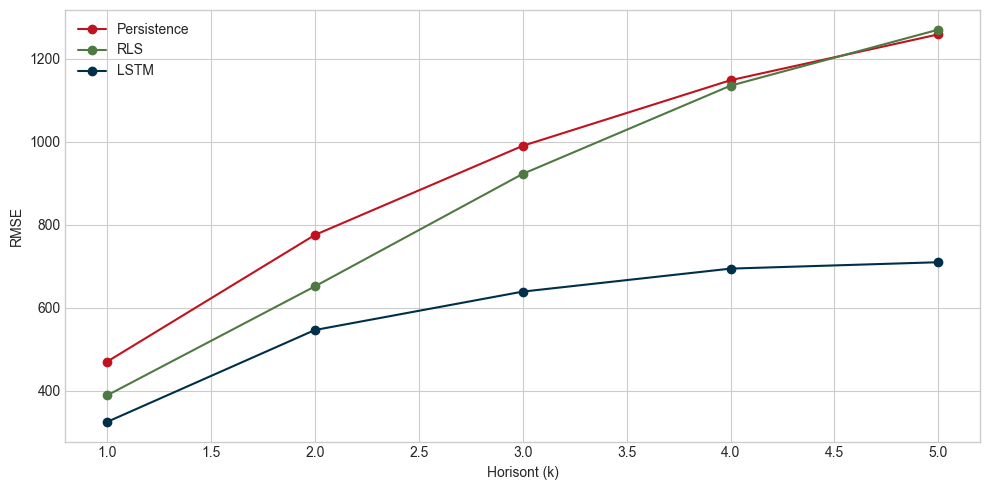


Extreme RMSE values by model (average over runs for LSTM):
Persistence (ekstreme): {1: 857.897, 2: 1134.963, 3: 1328.355, 4: 1534.897, 5: 1743.086}
RLS (ekstreme):        {1: 749.918, 2: 967.277, 3: 1293.184, 4: 1593.808, 5: 1780.651}
LSTM (ekstreme):      {1: 665.739, 2: 1223.246, 3: 1415.421, 4: 1479.976, 5: 1535.846}


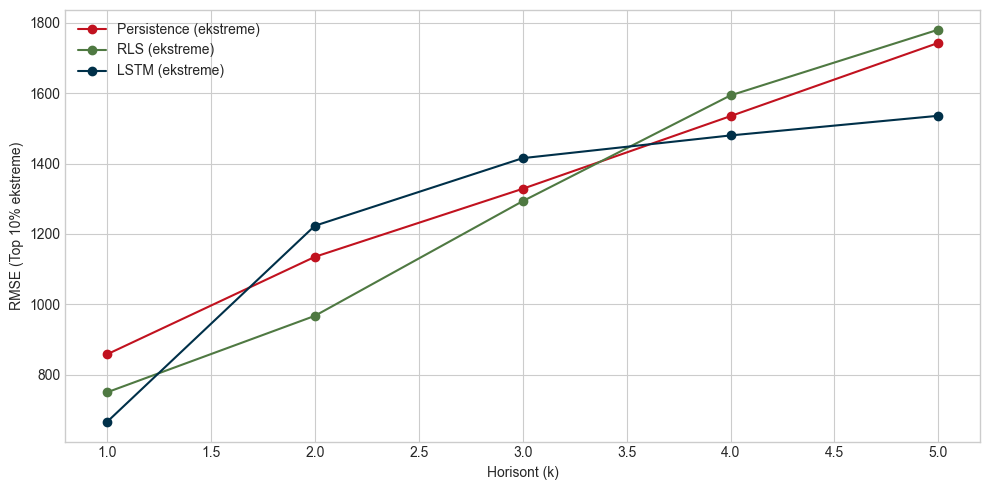

In [74]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # -------------------------------
# # Global Settings & Colors
# # -------------------------------
# plt.style.use('seaborn-v0_8-whitegrid')
# colors = {
#     "barn_red": "#780000",
#     "fire_brick": "#c1121f",
#     "fern_green": "#4F7942",
#     "prussian_blue": "#003049"
# }

# # -------------------------------
# # Helper Functions
# # -------------------------------
# def low_pass(series, a1=0.9):
#     return series.ewm(alpha=1 - a1, adjust=False).mean().values

# def rls_initialize(n_params, delta=1000):
#     return np.zeros(n_params), delta * np.eye(n_params)

# def rls_update(theta, P, x_t, y_t, lam):
#     xcol = x_t.reshape(-1, 1)
#     denom = lam + (xcol.T @ P @ xcol).item()
#     K = (P @ xcol) / denom
#     err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
#     theta = theta + (K.flatten() * err)
#     P = (P - K @ xcol.T @ P) / lam
#     return theta, P

# def online_rls_k(df, lam, a1, delta, k, extra_features=None):
#     D = df.copy()
#     D['t'] = pd.to_datetime(D['time'])
#     D.set_index('t', inplace=True)

#     y_arr = D['KarupBro'].values
#     prec = D['precip_total_daily'].values
#     n = len(D); m = k - 1

#     # baseline precip forecast
#     prec_pred = np.full(n, np.nan)
#     prec_pred[:n - m] = prec[m:]
#     prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

#     # lag-1 inflow
#     y_lag1 = np.full(n, np.nan)
#     y_lag1[1:] = y_arr[:-1]

#     # extra features
#     extra_preds = {}
#     if extra_features:
#         for f in extra_features:
#             arr = D[f].values
#             arr_pred = np.full(n, np.nan)
#             arr_pred[:n - m] = arr[m:]
#             if f == 'precip_total_daily':
#                 arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
#             extra_preds[f] = arr_pred

#     # initialize RLS
#     n_params = 3 + (len(extra_features) if extra_features else 0)
#     theta, P = rls_initialize(n_params, delta)

#     # online predict + update
#     yhat = np.full(n, np.nan)
#     for t in range(m + 1, n):
#         x = [1.0, y_lag1[t], prec_lp[t]]
#         if extra_features:
#             for f in extra_features:
#                 x.append(extra_preds[f][t])
#         x_t = np.array(x)
#         yhat[t] = x_t @ theta
#         if not np.isnan(y_arr[t]):
#             theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

#     return pd.Series(yhat, index=D.index, name=f'k{k}')

# def score(residuals, mask=None):
#     if mask is not None:
#         residuals = residuals[mask]
#     return np.sqrt(np.nanmean(residuals**2))

def plot_rmse(rmse_dict, horizons):
    fig, ax = plt.subplots(figsize=(10, 5))
    model_colors = {
        "Persistence": colors["fire_brick"],
        "RLS": colors["fern_green"],
        "LSTM": colors["prussian_blue"]
    }
    for model_name, rmse in rmse_dict.items():
        ax.plot(horizons, rmse.values, marker='o', label=model_name,
                color=model_colors.get(model_name, 'black'))
    ax.set_xlabel("Horisont (k)")
    ax.set_ylabel("RMSE")
    ax.legend()
    plt.tight_layout()
    plt.show()

#     print("\nRMSE values by model:")
#     for model_name, rmse in rmse_dict.items():
#         print(f"{model_name}: {rmse.round(3).to_dict()}")

# def persistence(df, horizons):
#     forecasts = pd.DataFrame(index=df.index)
#     for k in horizons:
#         forecasts[f'k{k}'] = df['y'].shift(1)
#     return forecasts

# # -------------------------------
# # Offline Dataset & Model Builder
# # -------------------------------
# def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
#     Xh, Xf, y_arr, idxs = [], [], [], []
#     n = len(df)
#     for i in range(window_size, n - (k - 1)):
#         idx = i + (k - 1)
#         Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
#         Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
#         y_arr.append(float(df['y'].iloc[idx]))
#         idxs.append(df.index[idx])
#     return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

# def build_model(window_size, n_hist, n_fcst):
#     hist_input = Input(shape=(window_size, n_hist))
#     x = LSTM(64, activation='relu')(hist_input)
#     x = Dense(64, activation='relu')(x)
#     fcst_input = Input(shape=(n_fcst,))
#     yb = Dense(32, activation='relu')(fcst_input)
#     yb = Dense(32, activation='relu')(yb)
#     combined = Concatenate()([x, yb])
#     combined = Dense(64, activation='relu')(combined)
#     output = Dense(1, activation='linear')(combined)
#     m = Model([hist_input, fcst_input], output)
#     m.compile(optimizer=Adam(0.001), loss='mse')
#     return m

# # -------------------------------
# # Data Loading & Preprocessing
# # -------------------------------
# data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
# D = pd.read_csv(data_path)

# D['t'] = pd.to_datetime(D['time'])
# D = D.set_index('t').sort_index()
# D['y'] = D['KarupBro']

# D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
# D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
# D['temp_mean_daily'].interpolate(inplace=True)
# D['precip_total_daily'].fillna(0, inplace=True)

# D['temp_forecast'] = D['temp_mean_daily']
# D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
# D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
# D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# score_period = D.index[-1023:]
# score_start = score_period[0]

# # -------------------------------
# # Forecasting Configs
# # -------------------------------
# horizons = [1, 2, 3, 4, 5]
# window_size = 10
# runs = 10

# rls_features = ['radiation_global_daily', 'precip_duration_daily']
# lam_opt = 0.95
# a1_opt = 0.5
# delta = 1000

# lstm_hist_base = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
# lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']
# lstm_extra = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
# hist_cols = lstm_hist_base + lstm_extra
# fcst_cols = lstm_fcst_base + lstm_extra

# # -------------------------------
# # RLS Forecasting
# # -------------------------------
# YhatR = pd.DataFrame(index=D.index)
# for k in horizons:
#     YhatR[f'k{k}'] = online_rls_k(D.reset_index(), lam_opt, a1_opt, delta, k, extra_features=rls_features)

# # -------------------------------
# # LSTM Forecasting with avg over runs
# # -------------------------------
# all_rmse_LSTM = []
# all_extreme_rmse_LSTM = []
# final_lstm_forecasts = {}

# for run in range(runs):
#     run_rmse = {}
#     run_extreme_rmse = {}
#     for k in horizons:
#         Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
#         mask_test = idxs >= score_start
#         Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
#         Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
#         y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

#         model = build_model(window_size, Xh.shape[2], Xf.shape[1])
#         es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         model.fit([Xh_tr, Xf_tr], y_tr,
#                   validation_split=0.2, epochs=50, batch_size=16,
#                   verbose=0, callbacks=[es])

#         preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
#         # full-period RMSE
#         run_rmse[k] = np.sqrt(np.nanmean((y_te - preds)**2))
#         # extreme RMSE (top 10%)
#         thr = np.quantile(y_te, 0.9)
#         mask_ext = y_te >= thr
#         run_extreme_rmse[k] = np.sqrt(np.nanmean((y_te[mask_ext] - preds[mask_ext])**2)) if mask_ext.sum()>0 else np.nan

#         if run == runs - 1:
#             final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

#     all_rmse_LSTM.append(pd.Series(run_rmse))
#     all_extreme_rmse_LSTM.append(pd.Series(run_extreme_rmse))

# avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)
# avg_extreme_rmse_LSTM = pd.concat(all_extreme_rmse_LSTM, axis=1).mean(axis=1)

# # -------------------------------
# # Persistence Forecasting
# # -------------------------------
# YhatP = persistence(D, horizons)

# # -------------------------------
# # RMSE Evaluation (Full Period)
# # -------------------------------
# targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
# mask = D.index.isin(score_period)

# rmse_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_LSTM = avg_rmse_LSTM

rmse_dict = {
    'Persistence': rmse_P,
    'RLS': rmse_R,
    'LSTM': rmse_LSTM
}

# -------------------------------
# Plot & Print RMSE
# -------------------------------
plot_rmse(rmse_dict, horizons)

# -------------------------------
# Print Extreme RMSE Values by Model
# -------------------------------
print("\nExtreme RMSE values by model (average over runs for LSTM):")
print(f"Persistence (ekstreme): {pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
print(f"RLS (ekstreme):        {pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask=mask & (D['y']>=np.percentile(D.loc[score_period,'y'],90))) for k in horizons}).round(3).to_dict()}")
print(f"LSTM (ekstreme):      {avg_extreme_rmse_LSTM.round(3).to_dict()}")

# -------------------------------
# Plot Extreme RMSE vs Horizon
# -------------------------------
threshold = np.percentile(D.loc[score_period, 'y'], 90)
mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, 
        [score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
        marker='o', label='Persistence (ekstreme)', color=colors['fire_brick'])
ax.plot(horizons, 
        [score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons],
        marker='o', label='RLS (ekstreme)',        color=colors['fern_green'])
ax.plot(horizons, avg_extreme_rmse_LSTM.values,
        marker='o', label='LSTM (ekstreme)', color=colors['prussian_blue'])
ax.set_xlabel('Horisont (k)')
ax.set_ylabel('RMSE (Top 10% ekstreme)')
ax.legend(); plt.tight_layout(); plt.show()

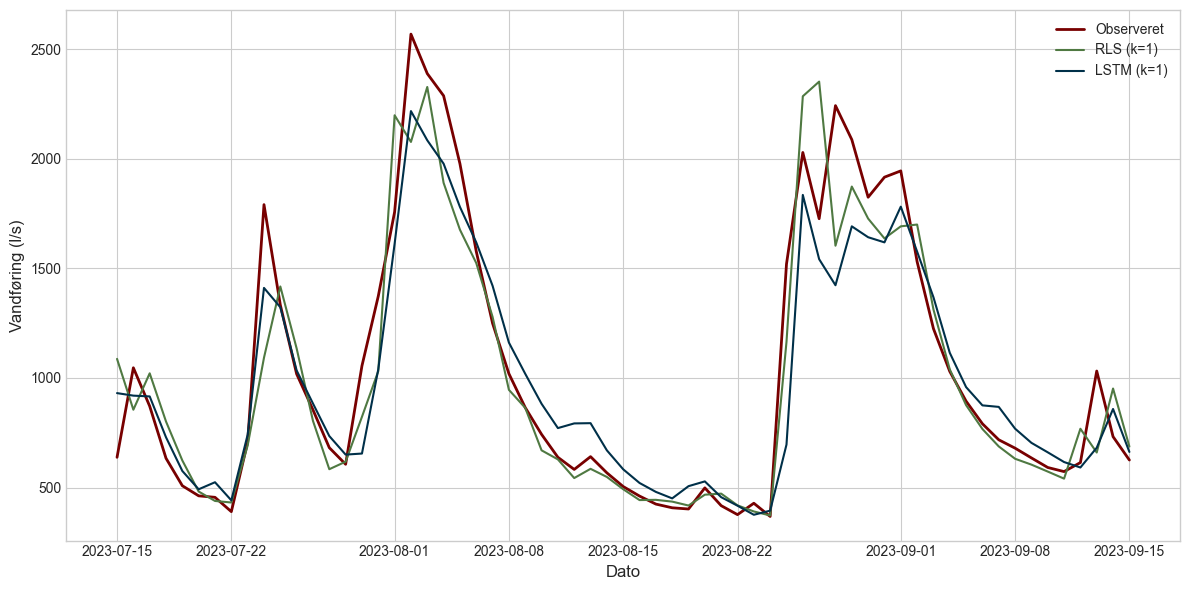

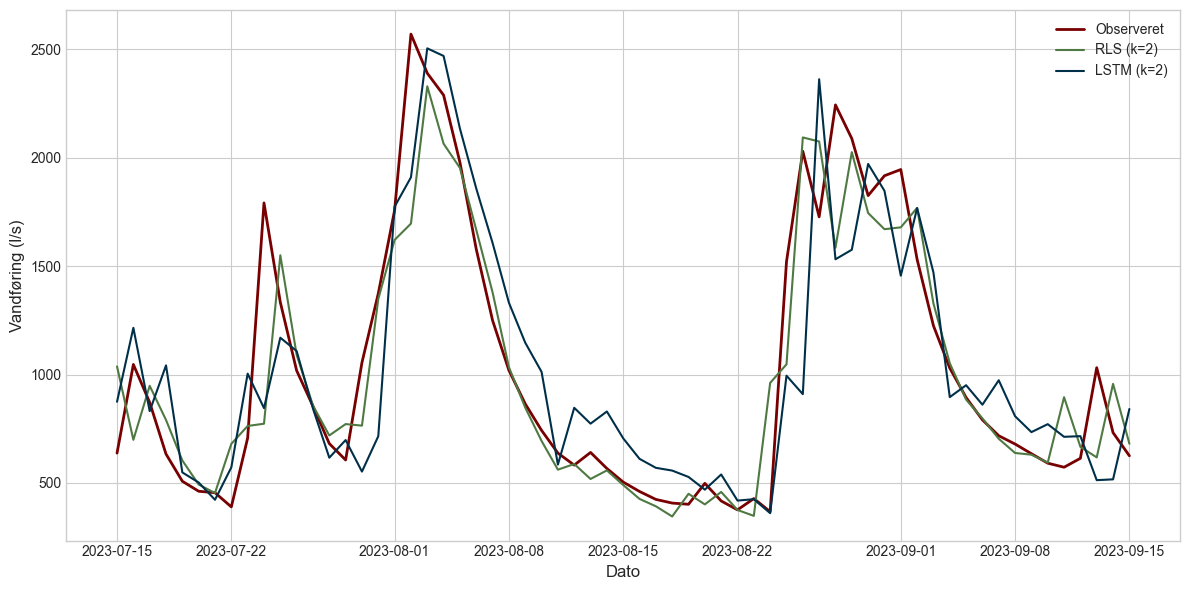

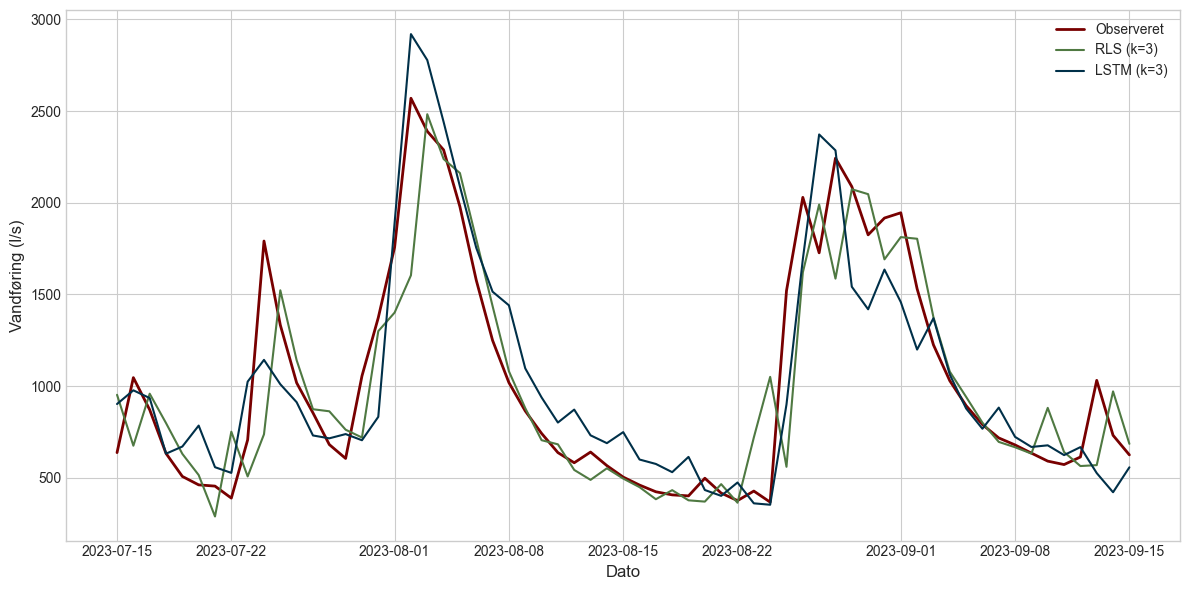

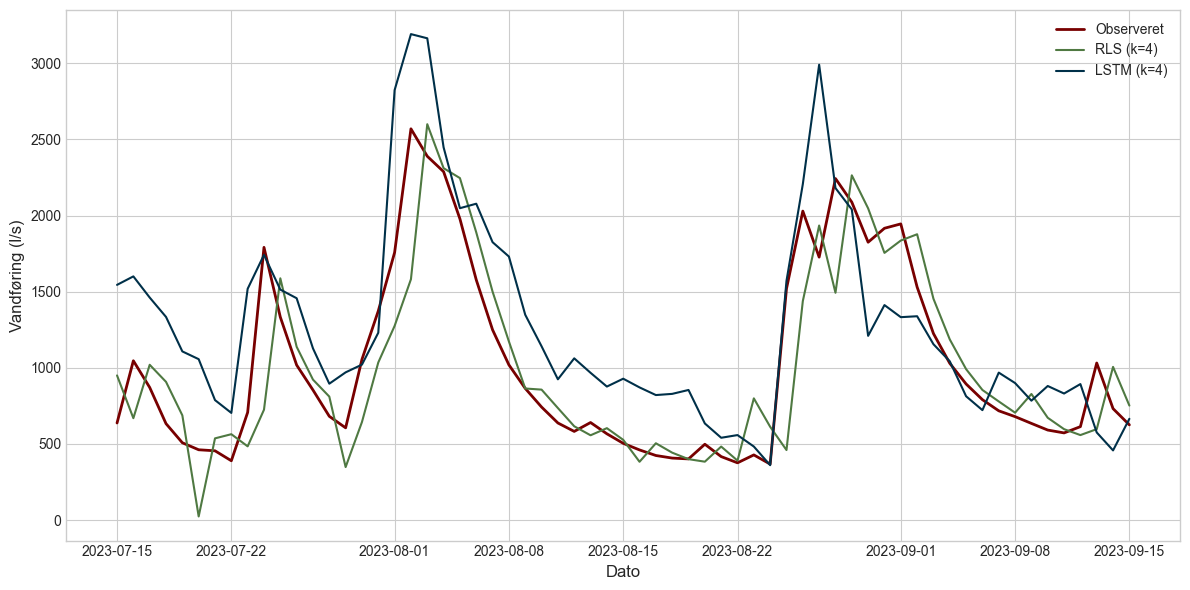

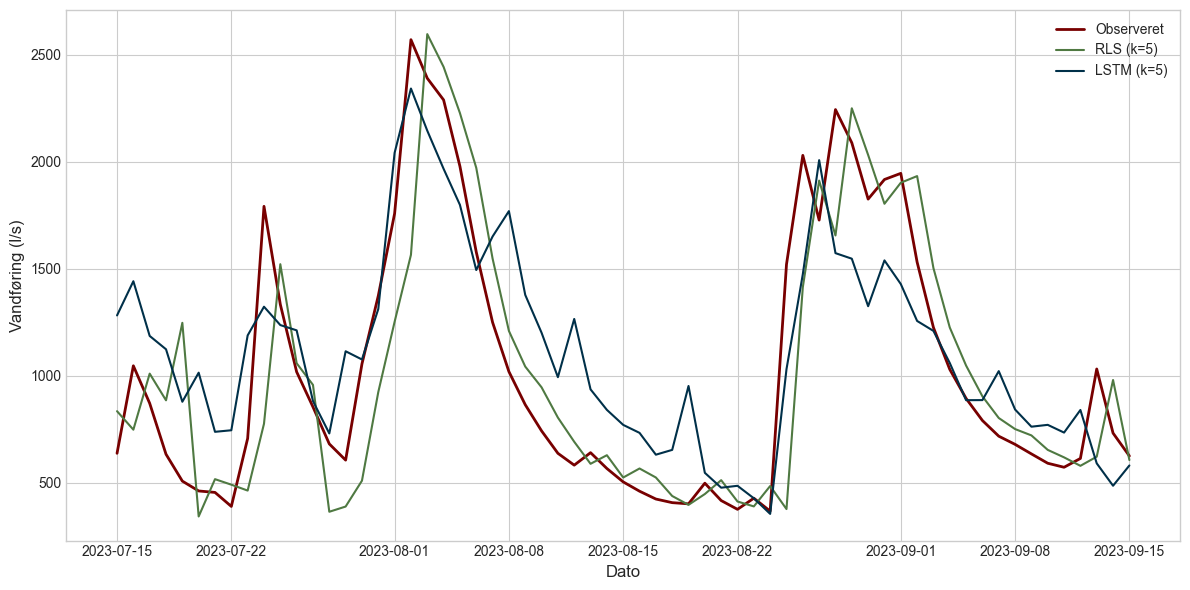

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Definér ønsket periode
zoom_start = pd.to_datetime('2023-07-15')
zoom_end   = pd.to_datetime('2023-09-15')
zoom_mask = (D.index >= zoom_start) & (D.index <= zoom_end)

for k in horizons:
    key = f'k{k}'
    
    # Skær serierne med mask
    obs  = D['y'][zoom_mask]
    rls  = YhatR[key][zoom_mask]
    lstm = final_lstm_forecasts[key].reindex(D.index)[zoom_mask]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(
        obs,
        label='Observeret',
        color=colors['barn_red'],
        linewidth=2
    )
    ax.plot(
        rls,
        label=f'RLS (k={k})',
        color=colors['fern_green'],
        linewidth=1.5
    )
    ax.plot(
        lstm,
        label=f'LSTM (k={k})',
        color=colors['prussian_blue'],
        linewidth=1.5
    )

    ax.set_xlabel('Dato', fontsize=12)
    ax.set_ylabel('Vandføring (l/s)', fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Andet?

In [13]:
# # Updated Forecasting Code with Separate Feature Sets for RLS and LSTM

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # -------------------------------
# # Global Settings & Colors
# # -------------------------------
# plt.style.use('seaborn-v0_8-whitegrid')
# colors = {
#     "barn_red": "#780000",
#     "fire_brick": "#c1121f",
#     "fern_green": "#4F7942",
#     "prussian_blue": "#003049"
# }

# # -------------------------------
# # Helper Functions
# # -------------------------------
# def low_pass(series, a1=0.9):
#     return series.ewm(alpha=1 - a1, adjust=False).mean().values

# def rls_initialize(n_params, delta=1000):
#     return np.zeros(n_params), delta * np.eye(n_params)

# def rls_update(theta, P, x_t, y_t, lam):
#     xcol = x_t.reshape(-1, 1)
#     denom = lam + (xcol.T @ P @ xcol).item()
#     K = (P @ xcol) / denom
#     err = y_t - (xcol.T @ theta.reshape(-1, 1)).item()
#     theta = theta + (K.flatten() * err)
#     P = (P - K @ xcol.T @ P) / lam
#     return theta, P

# def online_rls_k(df, lam, a1, delta, k, extra_features=None):
#     D = df.copy()
#     D['t'] = pd.to_datetime(D['time'])
#     D.set_index('t', inplace=True)

#     y_arr = D['KarupBro'].values
#     prec = D['precip_total_daily'].values
#     n = len(D); m = k - 1

#     prec_pred = np.full(n, np.nan)
#     prec_pred[:n - m] = prec[m:]
#     prec_lp = low_pass(pd.Series(prec_pred, index=D.index), a1)

#     y_lag1 = np.full(n, np.nan)
#     y_lag1[1:] = y_arr[:-1]

#     extra_preds = {}
#     if extra_features:
#         for f in extra_features:
#             arr = D[f].values
#             arr_pred = np.full(n, np.nan)
#             arr_pred[:n - m] = arr[m:]
#             if f == 'precip_total_daily':
#                 arr_pred = low_pass(pd.Series(arr_pred, index=D.index), a1)
#             extra_preds[f] = arr_pred

#     n_params = 3 + (len(extra_features) if extra_features else 0)
#     theta, P = rls_initialize(n_params, delta)

#     yhat = np.full(n, np.nan)
#     for t in range(m + 1, n):
#         x = [1.0, y_lag1[t], prec_lp[t]]
#         if extra_features:
#             for f in extra_features:
#                 x.append(extra_preds[f][t])
#         x_t = np.array(x)
#         yhat[t] = x_t @ theta
#         if not np.isnan(y_arr[t]):
#             theta, P = rls_update(theta, P, x_t, y_arr[t], lam)

#     return pd.Series(yhat, index=D.index, name=f'k{k}')

# def score(residuals, mask=None):
#     if mask is not None:
#         residuals = residuals[mask]
#     return np.sqrt(np.nanmean(residuals**2))

# def plot_rmse(rmse_dict, horizons):
#     fig, ax = plt.subplots(figsize=(10, 5))
#     model_colors = {
#         "Persistence Forecast": colors["fire_brick"],
#         "RLS Forecast": colors["fern_green"],
#         "LSTM Forecast": colors["prussian_blue"]
#     }
#     for model_name, rmse in rmse_dict.items():
#         ax.plot(horizons, rmse.values, marker='o', label=model_name,
#                 color=model_colors.get(model_name, 'black'))
#     ax.set_xlabel("Forecast Horizon (k)")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE vs. Forecast Horizon")
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

#     print("\nRMSE values by model:")
#     for model_name, rmse in rmse_dict.items():
#         print(f"{model_name}: {rmse.round(3).to_dict()}")

# def persistence(df, horizons):
#     forecasts = pd.DataFrame(index=df.index)
#     for k in horizons:
#         forecasts[f'k{k}'] = df['y'].shift(1)
#     return forecasts

# # -------------------------------
# # Data Loading & Preprocessing
# # -------------------------------
# data_path = "Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
# D = pd.read_csv(data_path)

# D['t'] = pd.to_datetime(D['time'])
# D = D.set_index('t').sort_index()
# D['y'] = D['KarupBro']

# D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
# D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0
# D['temp_mean_daily'].interpolate(inplace=True)
# D['precip_total_daily'].fillna(0, inplace=True)

# D['temp_forecast'] = D['temp_mean_daily']
# D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
# D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
# D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# score_period = D.index[-1023:]
# score_start = score_period[0]

# # -------------------------------
# # Forecasting Configs
# # -------------------------------
# horizons = [1, 2, 3, 4, 5]
# window_size = 10
# runs = 10

# rls_features = ['radiation_global_daily', 'precip_duration_daily']
# lam_opt = 0.95
# a1_opt = 0.5
# delta = 1000

# lstm_hist_base = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
# lstm_fcst_base = ['precip_forecast', 'Year_sin', 'Year_cos']
# lstm_extra = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
# hist_cols = lstm_hist_base + lstm_extra
# fcst_cols = lstm_fcst_base + lstm_extra

# # -------------------------------
# # RLS Forecasting
# # -------------------------------
# YhatR = pd.DataFrame(index=D.index)
# for k in horizons:
#     YhatR[f'k{k}'] = online_rls_k(D.reset_index(), lam_opt, a1_opt, delta, k, extra_features=rls_features)

# # -------------------------------
# # LSTM Forecasting
# # -------------------------------
# def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
#     Xh, Xf, y_arr, idxs = [], [], [], []
#     n = len(df)
#     for i in range(window_size, n - (k - 1)):
#         idx = i + (k - 1)
#         Xh.append(df[hist_cols].iloc[i - window_size:i].values.astype(np.float32))
#         Xf.append(df[fcst_cols].iloc[idx].values.astype(np.float32))
#         y_arr.append(float(df['y'].iloc[idx]))
#         idxs.append(df.index[idx])
#     return np.stack(Xh), np.stack(Xf), np.array(y_arr), np.array(idxs)

# def build_model(window_size, n_hist, n_fcst):
#     hist_input = Input(shape=(window_size, n_hist))
#     x = LSTM(64, activation='relu')(hist_input)
#     x = Dense(64, activation='relu')(x)
#     fcst_input = Input(shape=(n_fcst,))
#     yb = Dense(32, activation='relu')(fcst_input)
#     yb = Dense(32, activation='relu')(yb)
#     combined = Concatenate()([x, yb])
#     combined = Dense(64, activation='relu')(combined)
#     output = Dense(1, activation='linear')(combined)
#     m = Model([hist_input, fcst_input], output)
#     m.compile(optimizer=Adam(0.001), loss='mse')
#     return m

# all_rmse_LSTM = []
# final_lstm_forecasts = {}

# for run in range(runs):
#     run_rmse = {}
#     for k in horizons:
#         Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
#         mask_test = idxs >= score_start
#         Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
#         Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
#         y_tr, y_te = y_arr[~mask_test], y_arr[mask_test]

#         model = build_model(window_size, Xh.shape[2], Xf.shape[1])
#         es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         model.fit([Xh_tr, Xf_tr], y_tr, validation_split=0.2,
#                   epochs=50, batch_size=32, verbose=0, callbacks=[es])

#         preds = model.predict([Xh_te, Xf_te], verbose=0).flatten()
#         run_rmse[k] = np.sqrt(((y_te - preds)**2).mean())
#         if run == runs - 1:
#             final_lstm_forecasts[f'k{k}'] = pd.Series(preds, index=idxs[mask_test])

#     all_rmse_LSTM.append(pd.Series(run_rmse))

# avg_rmse_LSTM = pd.concat(all_rmse_LSTM, axis=1).mean(axis=1)

# # -------------------------------
# # Persistence Forecasting
# # -------------------------------
# YhatP = persistence(D, horizons)

# # -------------------------------
# # RMSE Evaluation (Full Period)
# # -------------------------------
# targets = {k: D['y'].shift(-(k - 1)) for k in horizons}
# mask = D.index.isin(score_period)

# rmse_P = pd.Series({f'k{k}': score(YhatP[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_R = pd.Series({f'k{k}': score(YhatR[f'k{k}'] - targets[k], mask=mask) for k in horizons})
# rmse_LSTM = pd.Series({f'k{k}': avg_rmse_LSTM[k] for k in horizons})

# rmse_dict = {
#     'Persistence Forecast': rmse_P,
#     'RLS Forecast': rmse_R,
#     'LSTM Forecast': rmse_LSTM
# }

# # -------------------------------
# # Plot RMSE (Full Period)
# # -------------------------------
# plot_rmse(rmse_dict, horizons)

# # -------------------------------
# # Plot Actual vs Predicted (k=1)
# # -------------------------------
# score_data = D.loc[score_period]

# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(score_data.index, score_data['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
# ax.plot(score_data.index,
#         YhatR['k1'].reindex(score_data.index),
#         label='RLS (k1)', color=colors['fern_green'], linewidth=1)
# ax.plot(score_data.index,
#         final_lstm_forecasts['k1'].reindex(score_data.index),
#         label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
# ax.plot(score_data.index,
#         YhatP['k1'].reindex(score_data.index),
#         label='Persistence (k1)', color=colors['fire_brick'], linestyle='--', linewidth=1)
# ax.set_xlabel('Dato'); ax.set_ylabel('Vandføring'); ax.set_title('Observeret vs Forecasted vandføring (k=1)')
# ax.legend(); plt.tight_layout(); plt.show()

# # First 30 days
# short = score_data.iloc[:30]
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(short.index, short['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
# ax.plot(short.index,
#         YhatR['k1'].reindex(short.index),
#         label='RLS (k1)', color=colors['fern_green'], linewidth=1)
# ax.plot(short.index,
#         final_lstm_forecasts['k1'].reindex(short.index),
#         label='LSTM (k1)', color=colors['prussian_blue'], linewidth=1)
# ax.plot(short.index,
#         YhatP['k1'].reindex(short.index),
#         label='Persistence (k1)', color=colors['fire_brick'], linestyle='--', linewidth=1)
# ax.set_xlabel('Dato'); ax.set_ylabel('Vandføring'); ax.set_title('Observeret vs Forecasted vandføring (Første 30 dage)')
# ax.legend(); plt.tight_layout(); plt.show()

# # -------------------------------
# # RMSE for Top 10% Extreme Observations
# # -------------------------------
# threshold = np.percentile(D.loc[score_period, 'y'], 90)
# mask_extreme = D['y'].ge(threshold) & D.index.isin(score_period)

# rmse_extreme_P = pd.Series({k: score(YhatP[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
# rmse_extreme_R = pd.Series({k: score(YhatR[f'k{k}'] - targets[k], mask_extreme) for k in horizons})
# rmse_extreme_L = pd.Series({k: score(final_lstm_forecasts[f'k{k}'] - targets[k], mask_extreme) for k in horizons})

# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(horizons, rmse_extreme_P.values, marker='o', label='Persistence (extreme)', color=colors['fire_brick'])
# ax.plot(horizons, rmse_extreme_R.values, marker='o', label='RLS (extreme)', color=colors['fern_green'])
# ax.plot(horizons, rmse_extreme_L.values, marker='o', label='LSTM (extreme)', color=colors['prussian_blue'])
# ax.set_xlabel('Forecast Horizon (k)')
# ax.set_ylabel('RMSE (Top 10% extremes)')
# ax.set_title('RMSE vs Horizon for Top 10% Extreme Observations')
# ax.legend(); plt.tight_layout(); plt.show()

# # -------------------------------
# # Actual vs. Predicted (k=1) – Highlight Extreme Observations
# # -------------------------------
# extreme_mask = score_data['y'] >= threshold
# plt.figure(figsize=(12, 6))
# plt.plot(score_data.index, score_data['y'], label='Observeret', color=colors['barn_red'], linewidth=2)
# plt.scatter(score_data.index[extreme_mask], score_data['y'][extreme_mask],
#             color=colors['fire_brick'], label='Ekstreme (top 10%)', zorder=5)
# plt.xlabel('Dato'); plt.ylabel('Vandføring (l/s)')
# plt.title('Observeret vs Forudsiget (k=1) med Ekstreme Hændelser')
# plt.legend(); plt.tight_layout(); plt.show()

# Ekstra plots:

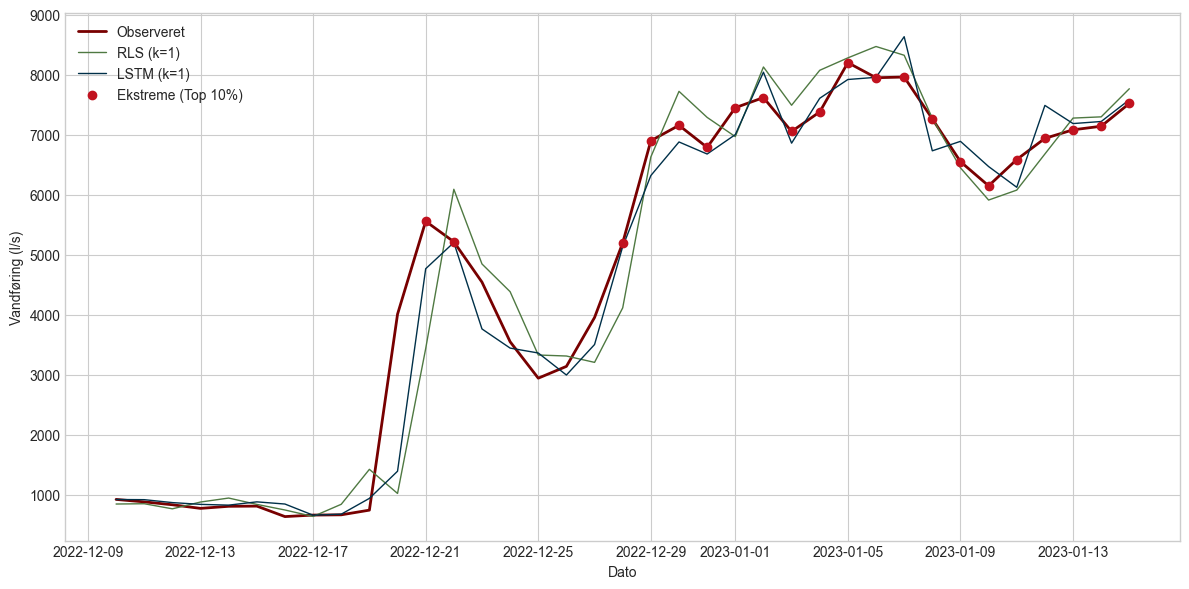

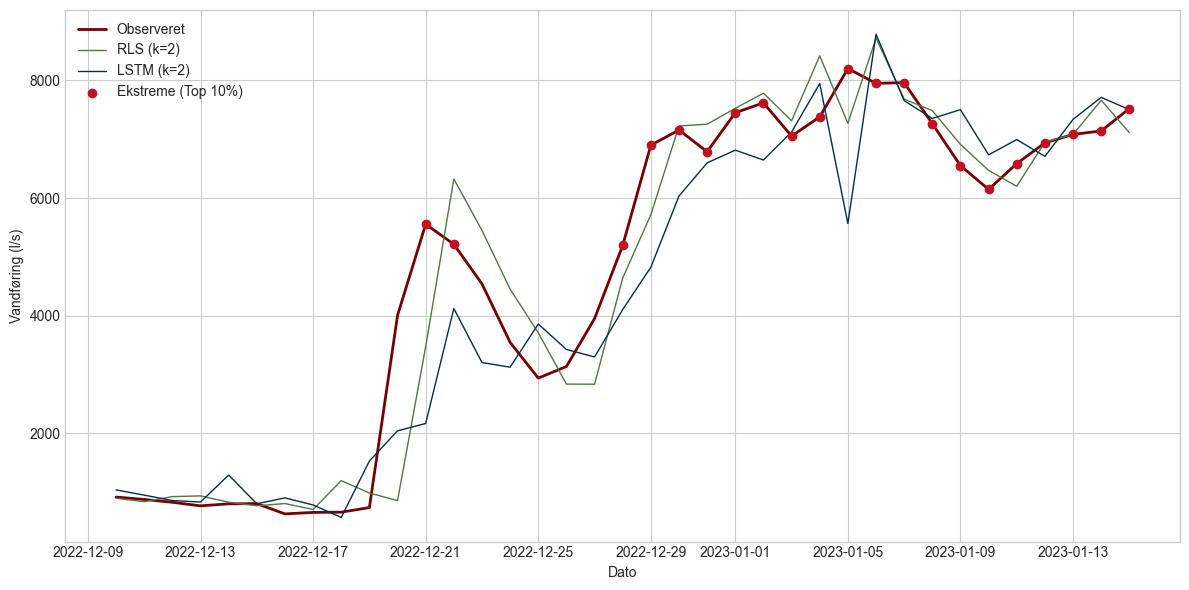

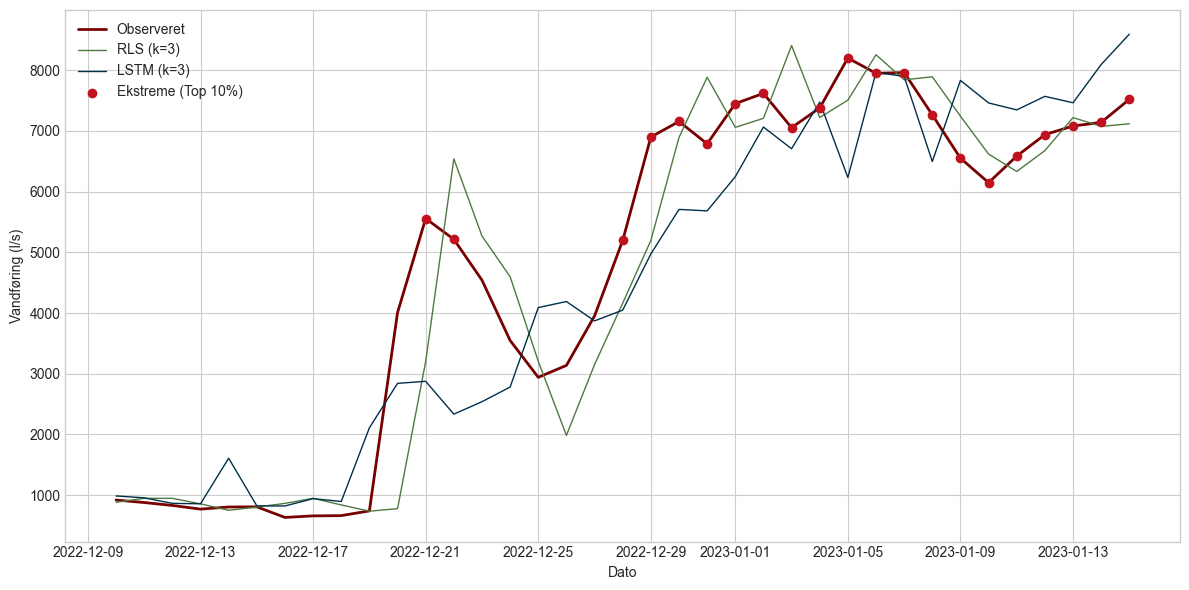

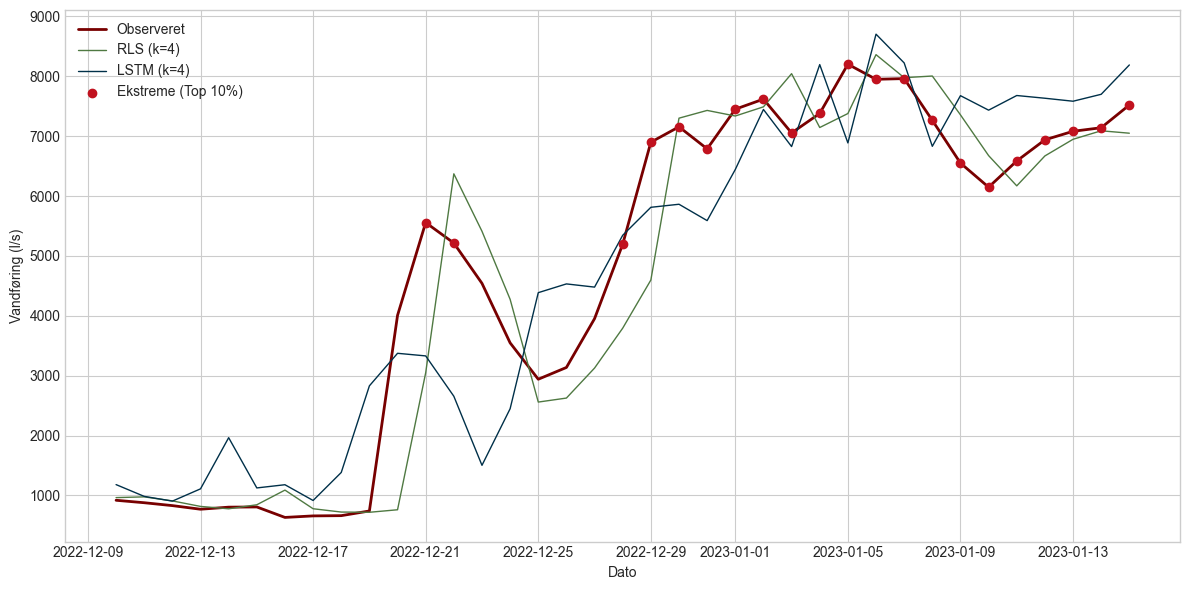

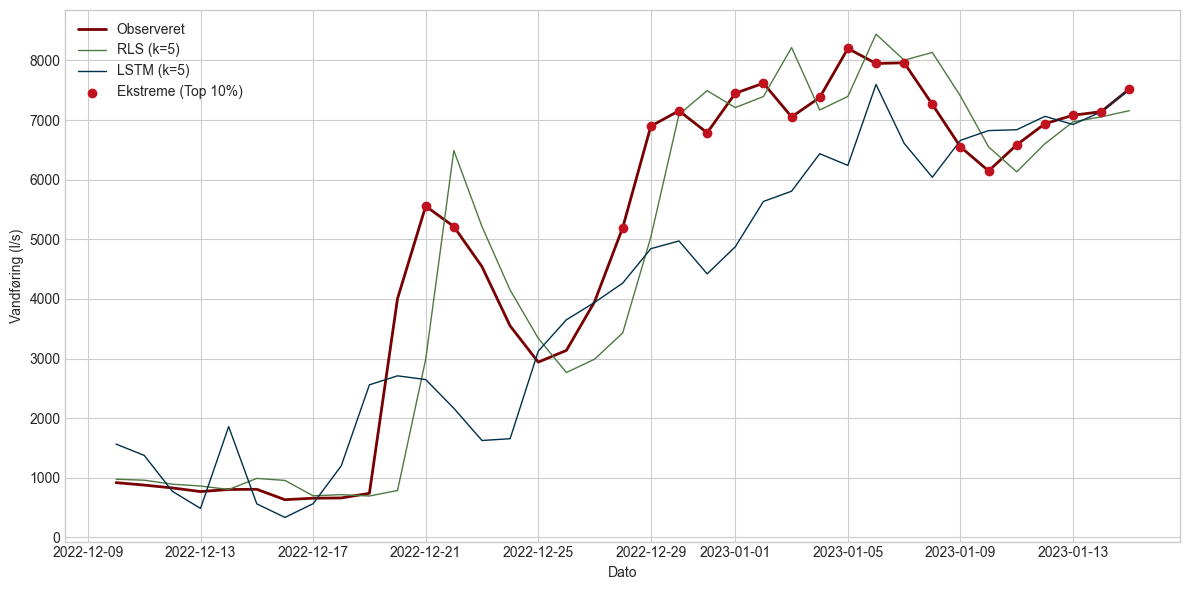

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Definér zoom-periode
start, end = '2022-12-10', '2023-01-15'
mask_zoom = (D.index >= start) & (D.index <= end)

# Genbrug threshold fra din score-periode
threshold = np.percentile(D.loc[score_period, 'y'], 90)

# Mask for ekstreme events i zoom-intervallet
mask_extreme_zoom = mask_zoom & (D['y'] >= threshold)

# Loop over horizons 2–5
for k in range(1, 6):
    key = f'k{k}'
    lstm_k = final_lstm_forecasts[key].reindex(D.index)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Observeret
    ax.plot(
        D.loc[mask_zoom, 'y'],
        label='Observeret',
        color=colors['barn_red'],
        linewidth=2
    )
    
    # RLS forudsigelse
    ax.plot(
        YhatR.loc[mask_zoom, key],
        label=f'RLS (k={k})',
        color=colors['fern_green'],
        linewidth=1
    )
    
    # LSTM forudsigelse
    ax.plot(
        lstm_k.loc[mask_zoom],
        label=f'LSTM (k={k})',
        color=colors['prussian_blue'],
        linewidth=1
    )
    
    # Scatter ekstrem-punkter
    ax.scatter(
        D.index[mask_extreme_zoom],
        D['y'][mask_extreme_zoom],
        color=colors['fire_brick'],
        label='Ekstreme (Top 10%)',
        zorder=5
    )
    
    ax.set_xlabel('Dato')
    ax.set_ylabel('Vandføring (l/s)')
    ax.legend()
    plt.tight_layout()
    plt.show()


CSI for Persistence Forecasts: [0.7226890756302521, 0.553030303030303, 0.4642857142857143, 0.3945578231292517, 0.3576158940397351]
CSI for RLS Forecasts: [0.8198198198198198, 0.5736434108527132, 0.45652173913043476, 0.3835616438356164, 0.3624161073825503]
CSI for LSTM Forecasts: [0.8666666666666667, 0.5344827586206896, 0.48760330578512395, 0.4596774193548387, 0.36363636363636365]


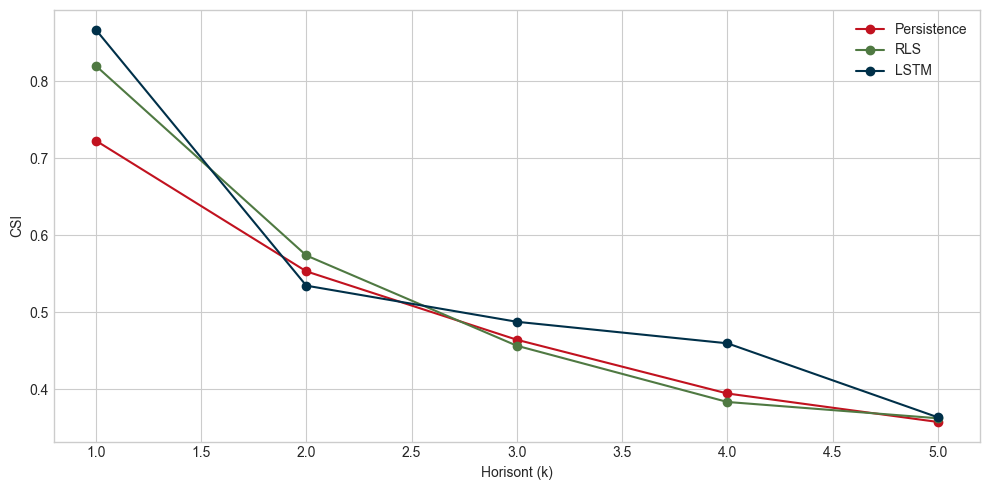

In [71]:
##########################################
# Compute and Plot CSI for Each Model
##########################################
# Define CSI function for binary events
def compute_csi(y_true, y_pred, threshold):
    # Binary events: 1 if value >= threshold, else 0
    obs = (y_true >= threshold).astype(int)
    pred = (y_pred >= threshold).astype(int)
    tp = np.sum((obs == 1) & (pred == 1))
    fn = np.sum((obs == 1) & (pred == 0))
    fp = np.sum((obs == 0) & (pred == 1))
    # CSI = TP / (TP + FN + FP)
    return tp / (tp + fn + fp) if (tp + fn + fp) > 0 else np.nan

# Calculate CSI across horizons
csi_P = []
csi_R = []
csi_L = []
for k in horizons:
    # Observed and forecasts for horizon k on score period
    y_obs = D['y'].shift(-(k-1)).loc[score_period]
    y_pred_P = YhatP[f'k{k}'].loc[score_period]
    y_pred_R = YhatR[f'k{k}'].loc[score_period]
    y_pred_L = final_lstm_forecasts[f'k{k}'].reindex(score_period)
    # compute CSI for each
    csi_P.append(compute_csi(y_obs.values, y_pred_P.values, threshold))
    csi_R.append(compute_csi(y_obs.values, y_pred_R.values, threshold))
    csi_L.append(compute_csi(y_obs.values, y_pred_L.values, threshold))


# Print out values
print("CSI for Persistence Forecasts:", csi_P)
print("CSI for RLS Forecasts:", csi_R)
print("CSI for LSTM Forecasts:", csi_L)

# Plot CSI vs Horizon
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(horizons, csi_P, marker='o', label='Persistence', color=colors['fire_brick'])
ax.plot(horizons, csi_R, marker='o', label='RLS', color=colors['fern_green'])
ax.plot(horizons, csi_L, marker='o', label='LSTM', color=colors['prussian_blue'])
ax.set_xlabel('Horisont (k)')
ax.set_ylabel('CSI')
ax.legend()
plt.tight_layout()
plt.show()

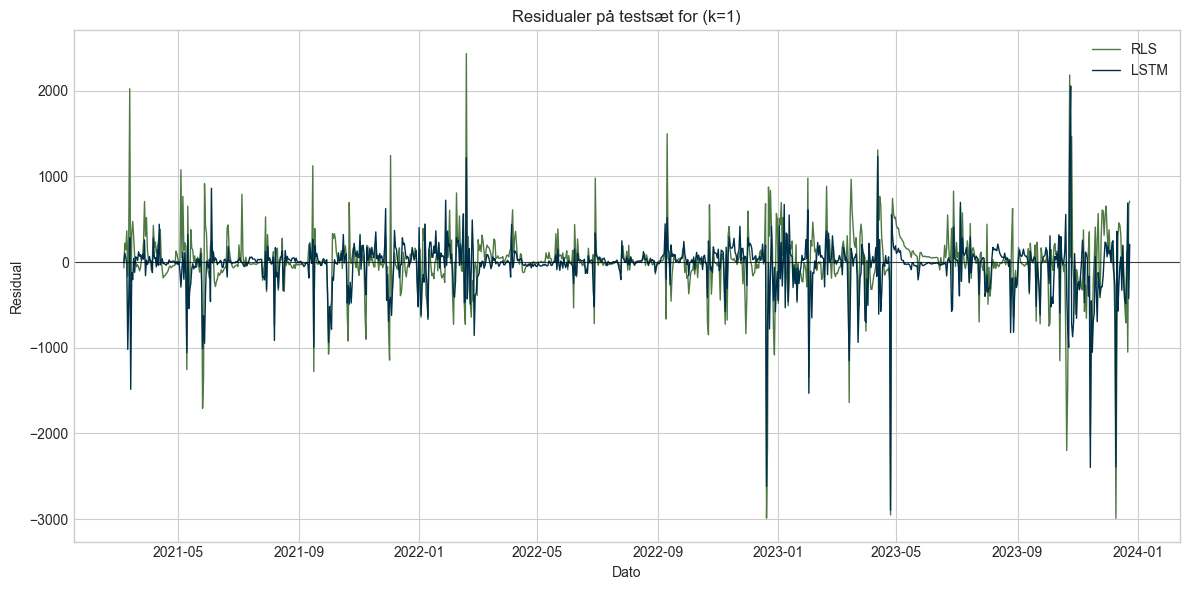

--- k=1 (All Test Data) ---
Mean RLS Residual:   1.770
Median RLS Residual: 5.909
Mean LSTM Residual:  -37.778
Median LSTM Residual:6.663



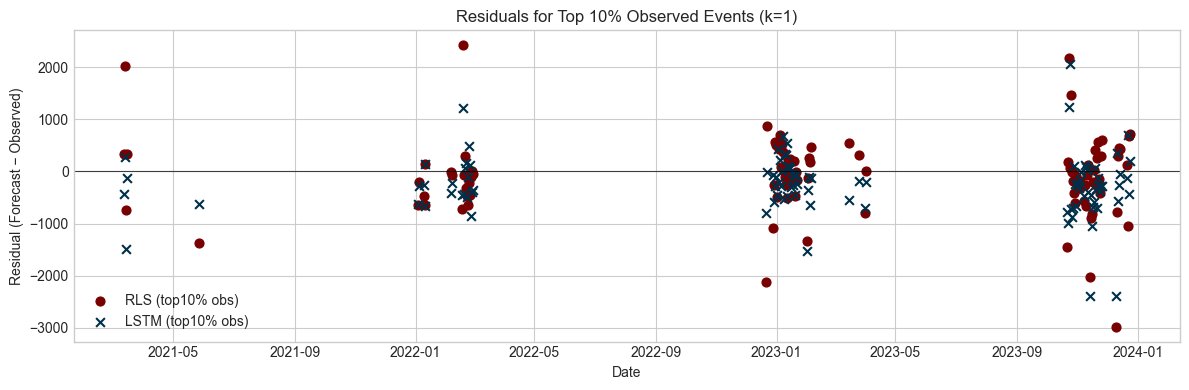

--- k=1 (Top 10% Observed) ---
Threshold y:           4611.924
Mean RLS Residual:     -89.420
Median RLS Residual:   -74.529
Mean LSTM Residual:    -250.331
Median LSTM Residual:  -261.805



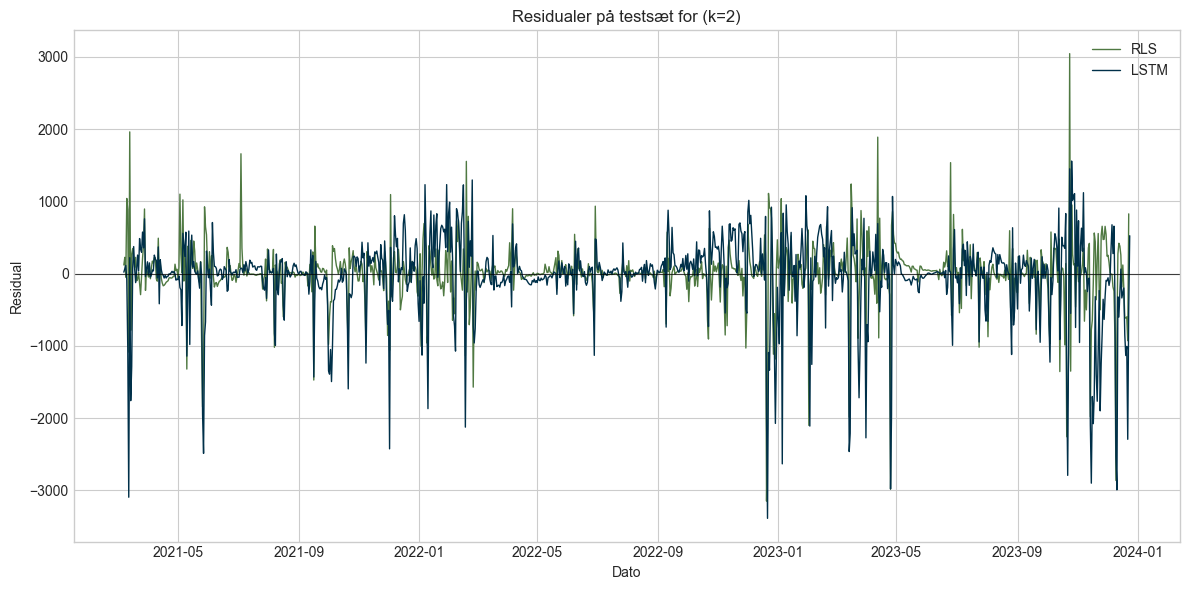

--- k=2 (All Test Data) ---
Mean RLS Residual:   4.586
Median RLS Residual: 19.681
Mean LSTM Residual:  -33.274
Median LSTM Residual:25.162



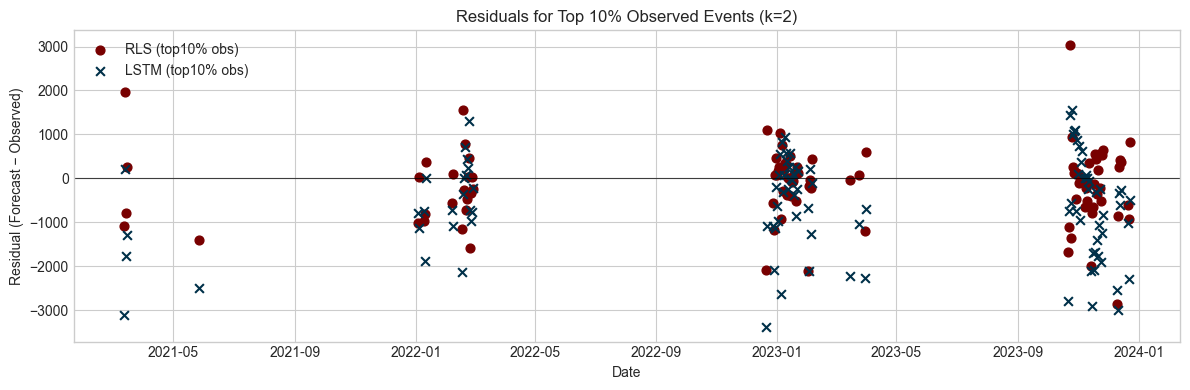

--- k=2 (Top 10% Observed) ---
Threshold y:           4611.924
Mean RLS Residual:     -147.591
Median RLS Residual:   -26.470
Mean LSTM Residual:    -631.071
Median LSTM Residual:  -518.410



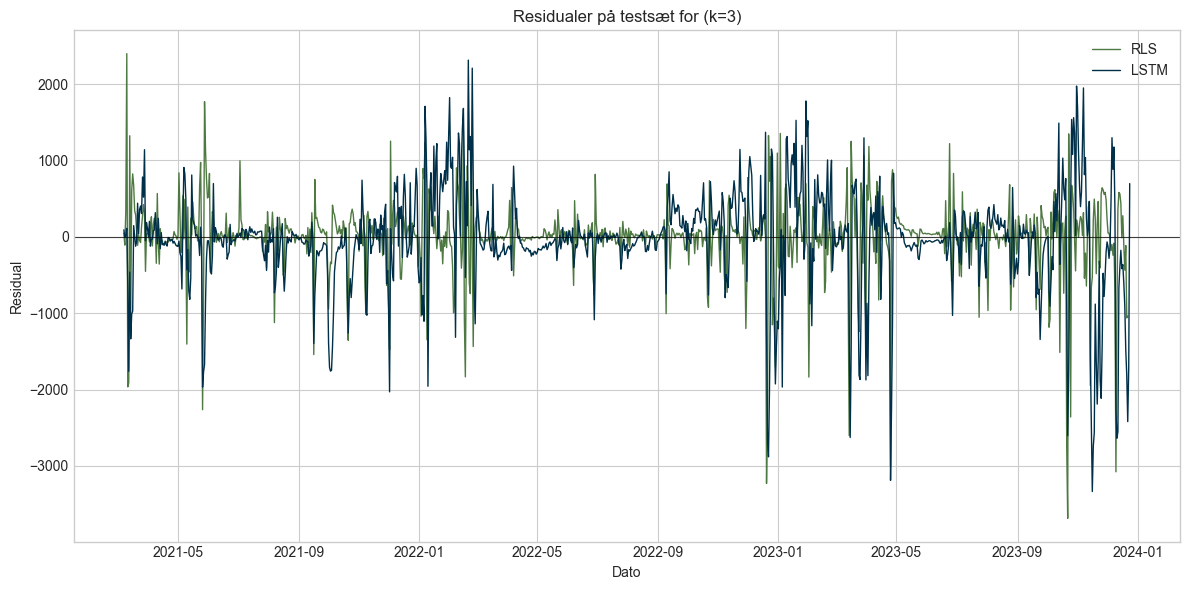

--- k=3 (All Test Data) ---
Mean RLS Residual:   -2.592
Median RLS Residual: 27.373
Mean LSTM Residual:  -34.887
Median LSTM Residual:-19.630



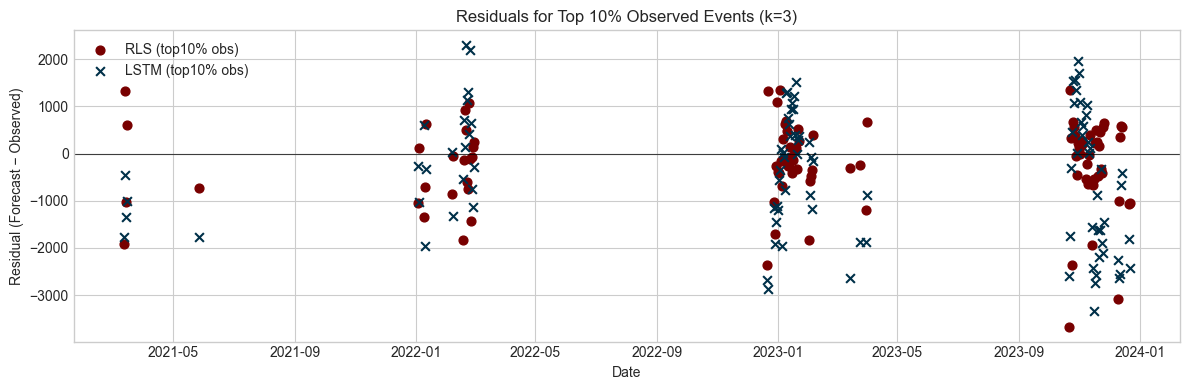

--- k=3 (Top 10% Observed) ---
Threshold y:           4611.924
Mean RLS Residual:     -217.647
Median RLS Residual:   -73.662
Mean LSTM Residual:    -455.327
Median LSTM Residual:  -320.326



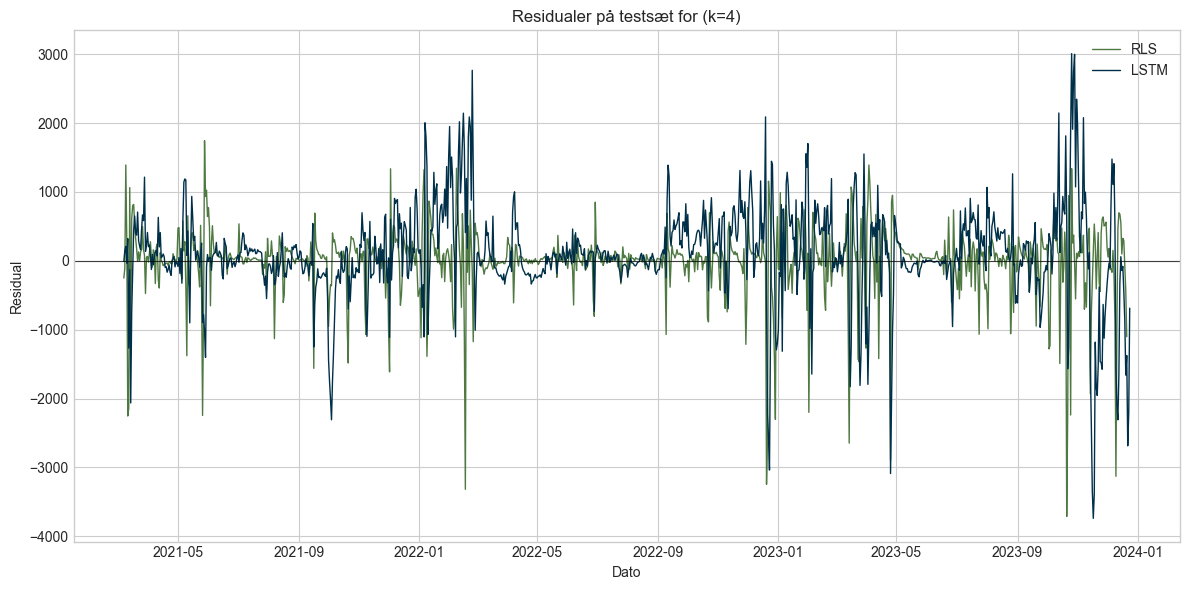

--- k=4 (All Test Data) ---
Mean RLS Residual:   1.210
Median RLS Residual: 44.799
Mean LSTM Residual:  103.809
Median LSTM Residual:74.672



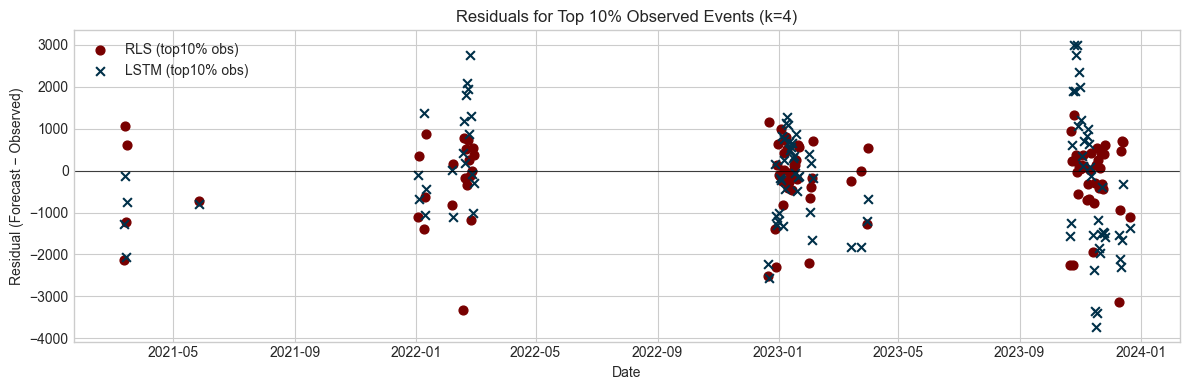

--- k=4 (Top 10% Observed) ---
Threshold y:           4611.924
Mean RLS Residual:     -200.044
Median RLS Residual:   -1.925
Mean LSTM Residual:    -209.059
Median LSTM Residual:  -139.537



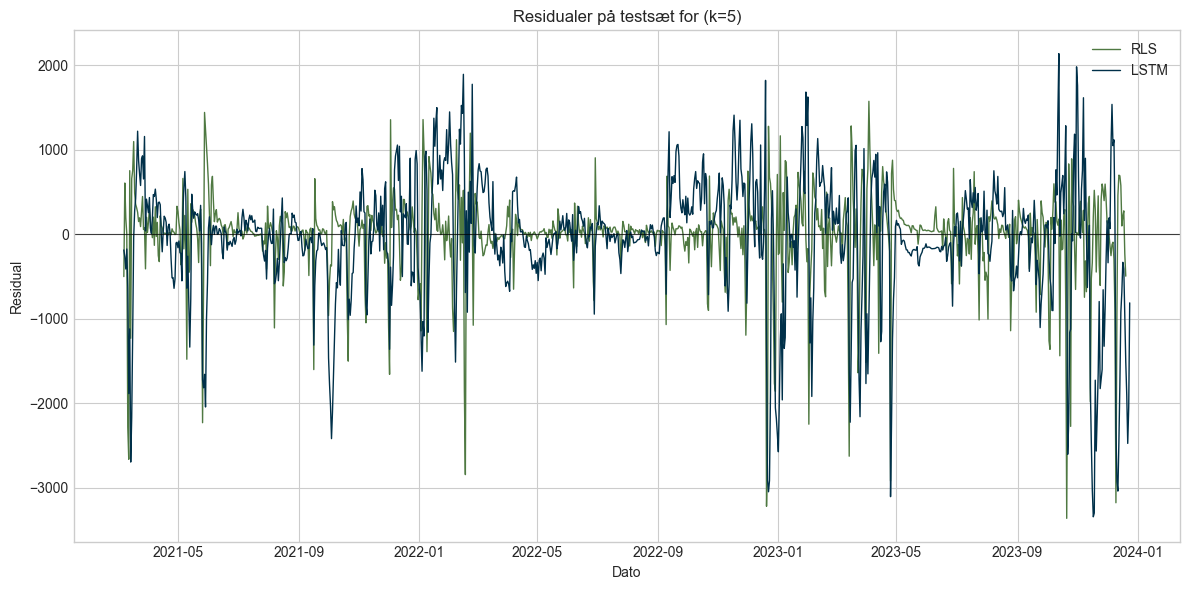

--- k=5 (All Test Data) ---
Mean RLS Residual:   -0.636
Median RLS Residual: 48.937
Mean LSTM Residual:  -48.865
Median LSTM Residual:8.077



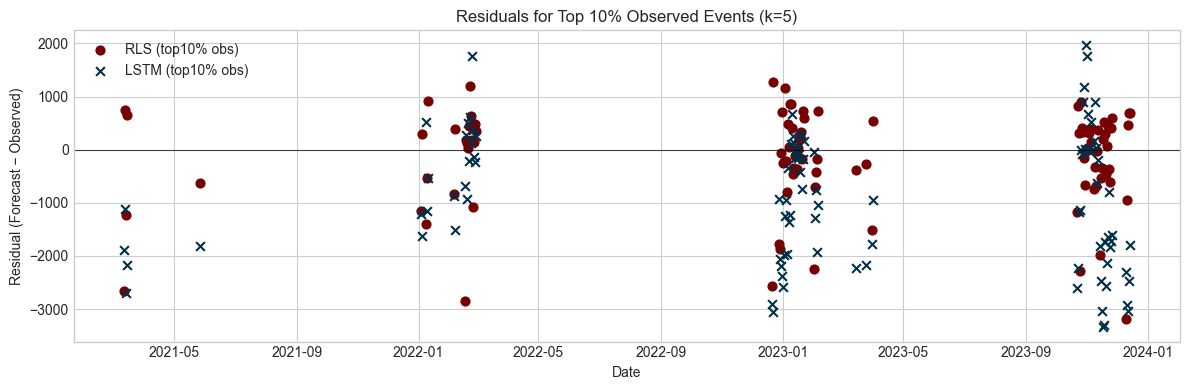

--- k=5 (Top 10% Observed) ---
Threshold y:           4611.924
Mean RLS Residual:     -175.204
Median RLS Residual:   24.652
Mean LSTM Residual:    -930.416
Median LSTM Residual:  -930.089



In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Forudsæt at D, YhatR, final_lstm_forecasts, score_start og colors er defineret

# 1) Udtræk test‐sættet og y_true
mask_test    = D.index >= score_start
idxs_test    = D.index[mask_test]
y_true_test  = D.loc[idxs_test, 'y']

# 2) Find tærsklen for top 10% af OBSERVEREDE y‐værdier
thr_obs       = np.nanpercentile(y_true_test, 90)
extreme_dates = y_true_test[y_true_test >= thr_obs].index

for k in range(1, 6):
    col = f'k{k}'
    
    # 3) Beregn prognoser og residualer
    pred_rls   = YhatR.loc[idxs_test, col]
    pred_lstm  = final_lstm_forecasts[col].reindex(idxs_test)
    res_rls    = pred_rls - y_true_test
    res_lstm   = pred_lstm - y_true_test
    
    # 4) Drop NaN for plot og statistik
    res_rls_clean   = res_rls.dropna()
    res_lstm_clean  = res_lstm.dropna()
    
    # A) Plot alle residualer
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(res_rls_clean.index, res_rls_clean, label='RLS',  linewidth=1, color=colors['fern_green'])
    ax.plot(res_lstm_clean.index, res_lstm_clean, label='LSTM', linewidth=1, color=colors['prussian_blue'])
    ax.axhline(0, color='black', linewidth=0.8, alpha=0.7)
    ax.set_title(f'Residualer på testsæt for (k={k})')
    ax.set_xlabel('Dato')
    ax.set_ylabel('Residual')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistik for alle data
    print(f"--- k={k} (All Test Data) ---")
    print(f"Mean RLS Residual:   {res_rls_clean.mean():.3f}")
    print(f"Median RLS Residual: {res_rls_clean.median():.3f}")
    print(f"Mean LSTM Residual:  {res_lstm_clean.mean():.3f}")
    print(f"Median LSTM Residual:{res_lstm_clean.median():.3f}\n")
    
    # B) Residualer for top 10% observerede hændelser
    valid_ext_dates = res_rls_clean.index.intersection(extreme_dates)
    ext_rls_obs      = res_rls_clean.loc[valid_ext_dates]
    ext_lstm_obs     = res_lstm_clean.loc[valid_ext_dates]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.scatter(ext_rls_obs.index,  ext_rls_obs,  label='RLS (top10% obs)', marker='o', s=40, color=colors['barn_red'])
    ax.scatter(ext_lstm_obs.index, ext_lstm_obs, label='LSTM (top10% obs)', marker='x', s=40, color=colors['prussian_blue'])
    ax.axhline(0, color='black', linewidth=0.8, alpha=0.7)
    ax.set_title(f'Residuals for Top 10% Observed Events (k={k})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual (Forecast − Observed)')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistik for ekstreme hændelser
    print(f"--- k={k} (Top 10% Observed) ---")
    print(f"Threshold y:           {thr_obs:.3f}")
    print(f"Mean RLS Residual:     {ext_rls_obs.mean():.3f}")
    print(f"Median RLS Residual:   {ext_rls_obs.median():.3f}")
    print(f"Mean LSTM Residual:    {ext_lstm_obs.mean():.3f}")
    print(f"Median LSTM Residual:  {ext_lstm_obs.median():.3f}\n")

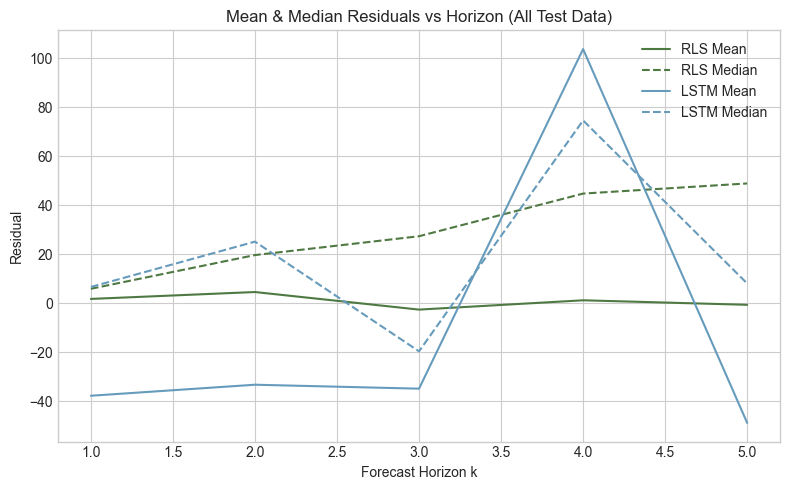

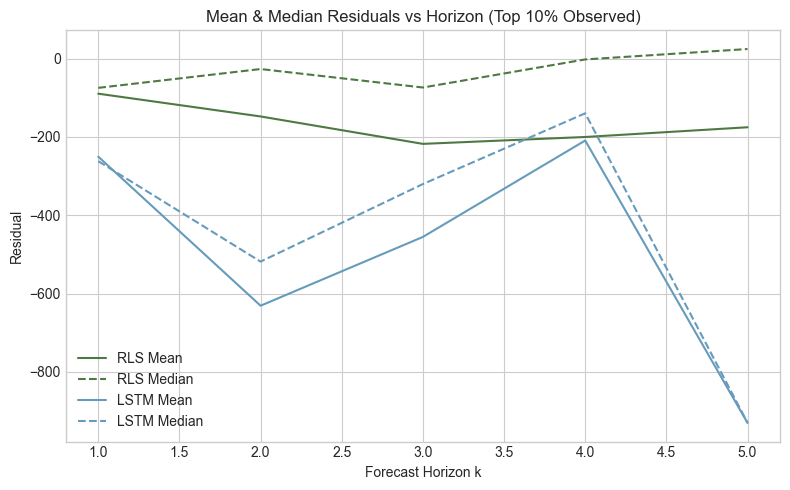

In [59]:
import matplotlib.pyplot as plt

# Residual metrics for horizons k = 1..5
ks = [1, 2, 3, 4, 5]

# All Test Data metrics
mean_rls_all   = [1.770,  4.586,  -2.592,  1.210,  -0.636]
median_rls_all = [5.909,  19.681,  27.373, 44.799, 48.937]
mean_lstm_all  = [-37.778, -33.274, -34.887, 103.809, -48.865]
median_lstm_all= [6.663,   25.162, -19.630,  74.672,   8.077]

# Top 10% Observed metrics
mean_rls_top   = [-89.420, -147.591, -217.647, -200.044, -175.204]
median_rls_top = [-74.529,  -26.470,  -73.662,   -1.925,   24.652]
mean_lstm_top  = [-250.331, -631.071, -455.327, -209.059, -930.416]
median_lstm_top= [-261.805, -518.410, -320.326, -139.537, -930.089]

# Plot for All Test Data
plt.figure(figsize=(8, 5))
plt.plot(ks, mean_rls_all,   label='RLS Mean',   color=colors['fern_green'], linestyle='-')
plt.plot(ks, median_rls_all, label='RLS Median', color=colors['fern_green'], linestyle='--')
plt.plot(ks, mean_lstm_all,  label='LSTM Mean',  color="#669bbc", linestyle='-')
plt.plot(ks, median_lstm_all,label='LSTM Median',color="#669bbc", linestyle='--')
plt.xlabel('Forecast Horizon k')
plt.ylabel('Residual')
plt.title('Mean & Median Residuals vs Horizon (All Test Data)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Top 10% Observed
plt.figure(figsize=(8, 5))
plt.plot(ks, mean_rls_top,   label='RLS Mean',   color=colors['fern_green'], linestyle='-')
plt.plot(ks, median_rls_top, label='RLS Median', color=colors['fern_green'], linestyle='--')
plt.plot(ks, mean_lstm_top,  label='LSTM Mean',  color="#669bbc", linestyle='-')
plt.plot(ks, median_lstm_top,label='LSTM Median',color="#669bbc", linestyle='--')
plt.xlabel('Forecast Horizon k')
plt.ylabel('Residual')
plt.title('Mean & Median Residuals vs Horizon (Top 10% Observed)')
plt.legend()
plt.tight_layout()
plt.show()

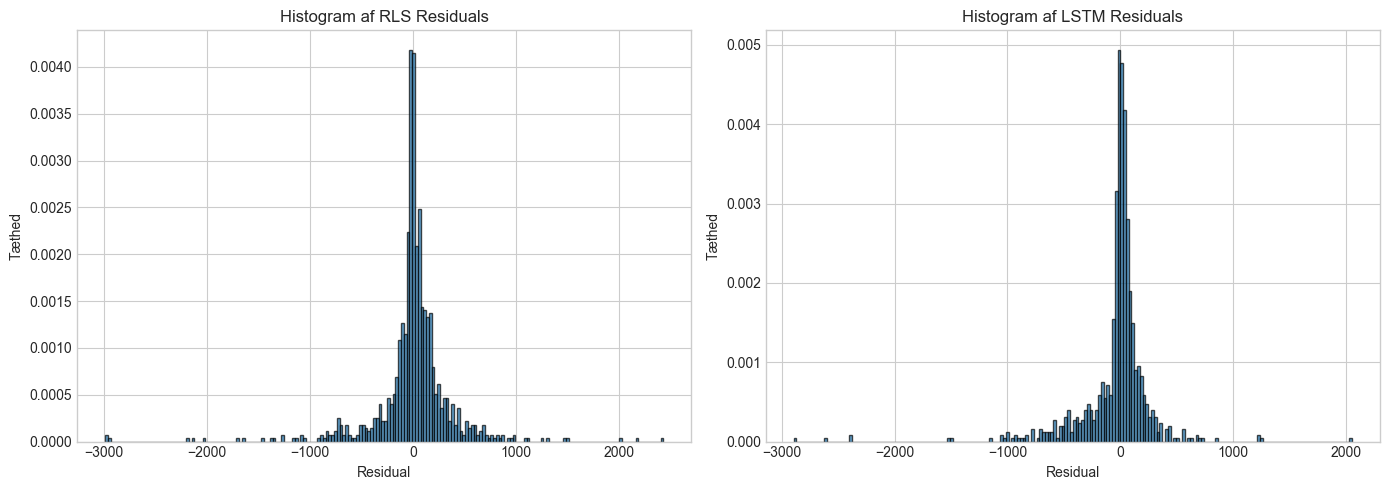

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Antag, at res_rls og res_lstm allerede er defineret som i dit script

# Opret to underplots til histogrammer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Histogram for RLS-residualer
axes[0].hist(res_rls, bins=200, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title('Histogram af RLS Residuals')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Tæthed')

# Histogram for LSTM-residualer
axes[1].hist(res_lstm, bins=200, density=True, alpha=0.7, edgecolor='black')
axes[1].set_title('Histogram af LSTM Residuals')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Tæthed')

plt.tight_layout()
plt.show()

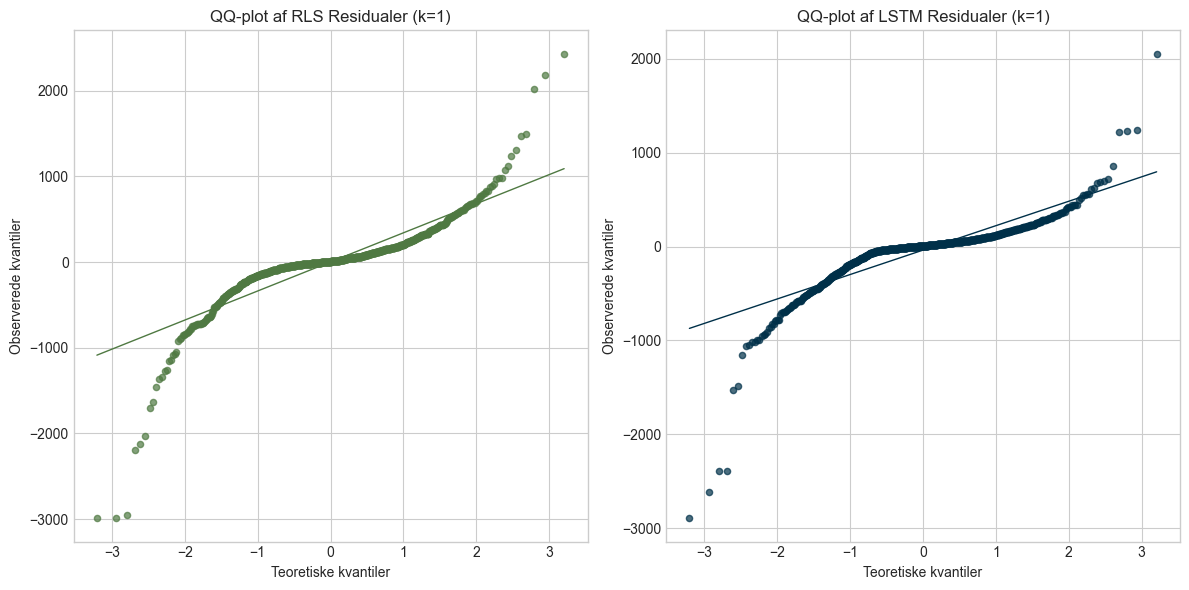

In [38]:
from scipy import stats
import matplotlib.pyplot as plt

# Beregn residualer som før:
mask_test    = D.index >= score_start
idxs_test    = D.index[mask_test]
y_true_test  = D.loc[idxs_test, 'y']
res_rls      = YhatR.loc[idxs_test, 'k1'] - y_true_test
res_lstm     = final_lstm_forecasts['k1'].reindex(idxs_test) - y_true_test

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- RLS QQ-plot ---
# stats.probplot returnerer ((theoretical, sample), (slope, intercept, r))
(theor_rls, sample_rls), (slope_rls, intercept_rls, _) = \
    stats.probplot(res_rls.dropna(), dist='norm', plot=None)

axes[0].scatter(
    theor_rls,
    sample_rls,
    color=colors['fern_green'],
    s=20,
    alpha=0.7
)
# reference-linje
axes[0].plot(
    theor_rls,
    slope_rls * theor_rls + intercept_rls,
    color=colors['fern_green'],
    linewidth=1
)
axes[0].set_title('QQ-plot af RLS Residualer (k=1)')
axes[0].set_xlabel('Teoretiske kvantiler')
axes[0].set_ylabel('Observerede kvantiler')

# --- LSTM QQ-plot ---
(theor_lstm, sample_lstm), (slope_lstm, intercept_lstm, _) = \
    stats.probplot(res_lstm.dropna(), dist='norm', plot=None)

axes[1].scatter(
    theor_lstm,
    sample_lstm,
    color=colors['prussian_blue'],
    s=20,
    alpha=0.7
)
axes[1].plot(
    theor_lstm,
    slope_lstm * theor_lstm + intercept_lstm,
    color=colors['prussian_blue'],
    linewidth=1
)
axes[1].set_title('QQ-plot af LSTM Residualer (k=1)')
axes[1].set_xlabel('Teoretiske kvantiler')
axes[1].set_ylabel('Observerede kvantiler')

plt.tight_layout()
plt.show()

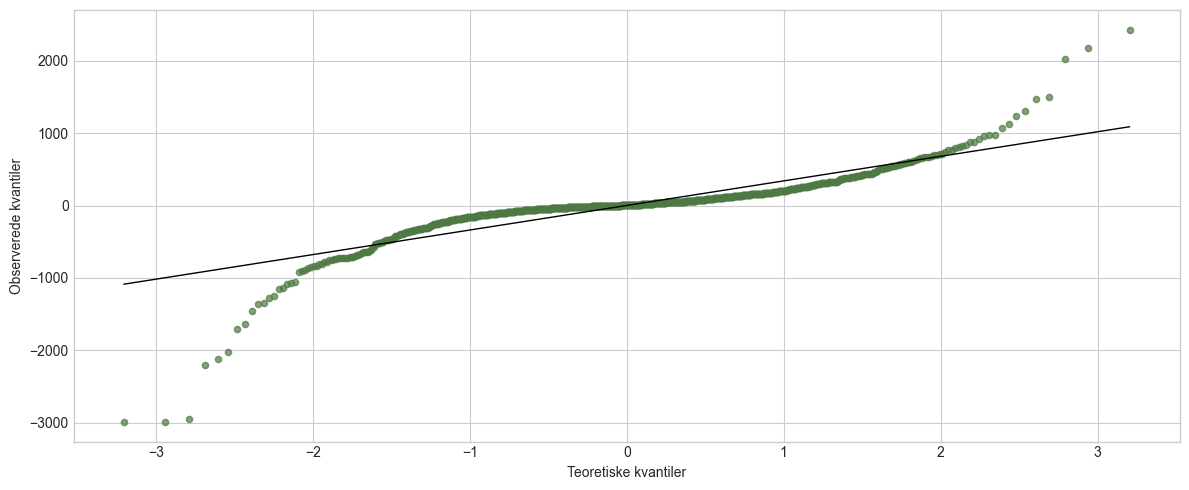

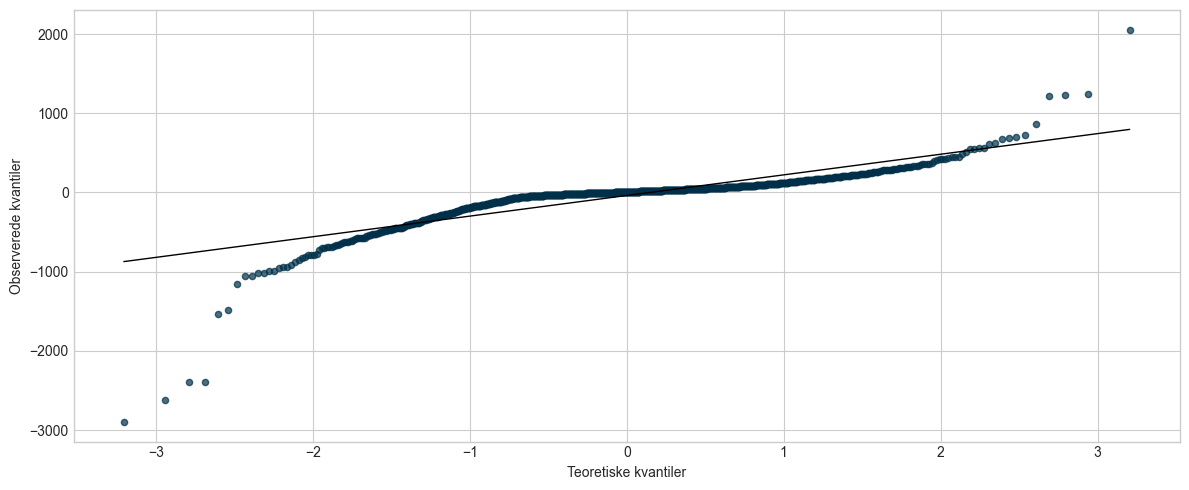

In [69]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Antag at D, YhatR, final_lstm_forecasts, score_start og colors er defineret

# 1) Udtræk test-sættet og y_true
mask_test   = D.index >= score_start
idxs_test   = D.index[mask_test]
y_true_test = D.loc[idxs_test, 'y']

# 2) Beregn residualer for k=1
res_rls   = (YhatR.loc[idxs_test, 'k1'] - y_true_test).dropna()
res_lstm  = (final_lstm_forecasts['k1'].reindex(idxs_test) - y_true_test).dropna()

# --- Figur 1: RLS QQ-plot ---
plt.figure(figsize=(12, 5))  # bred × høj
theor_rls, sample_rls = stats.probplot(res_rls, dist='norm', plot=None)[0]
slope_rls, intercept_rls = stats.probplot(res_rls, dist='norm', plot=None)[1][:2]

plt.scatter(theor_rls, sample_rls, color=colors['fern_green'], s=20, alpha=0.7)
plt.plot(theor_rls, slope_rls*theor_rls + intercept_rls, color='black', linewidth=1)
plt.xlabel('Teoretiske kvantiler')
plt.ylabel('Observerede kvantiler')
plt.tight_layout()
plt.savefig('qqplot_rls_k1.png', dpi=300)  # gem til LaTeX
plt.show()

# --- Figur 2: LSTM QQ-plot ---
plt.figure(figsize=(12, 5))
theor_lstm, sample_lstm = stats.probplot(res_lstm, dist='norm', plot=None)[0]
slope_lstm, intercept_lstm = stats.probplot(res_lstm, dist='norm', plot=None)[1][:2]

plt.scatter(theor_lstm, sample_lstm, color=colors['prussian_blue'], s=20, alpha=0.7)
plt.plot(theor_lstm, slope_lstm*theor_lstm + intercept_lstm, color='black', linewidth=1)
plt.xlabel('Teoretiske kvantiler')
plt.ylabel('Observerede kvantiler')
plt.tight_layout()
plt.savefig('qqplot_lstm_k1.png', dpi=300)
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Residual Calculation (k=1)
# -------------------------------
# Define test set mask
mask_test = D.index >= score_start

# Align indices for RLS and truth
idxs_test = D.index[mask_test]
y_true_test = D.loc[idxs_test, 'y']

# RLS residuals
res_rls = YhatR.loc[idxs_test, 'k1'] - y_true_test

# LSTM residuals
res_lstm = final_lstm_forecasts['k1'].reindex(idxs_test) - y_true_test

# ---------------------------------------------------
# Funktion til at beregne RMSE på en række residualer
# ---------------------------------------------------
def rmse(series):
    return np.sqrt(np.mean(series**2))

# ---------------------------------------------------
# 1) RMSE for første og sidste halvdel
# ---------------------------------------------------
n = len(idxs_test)
halv = n // 2

# Ved positionel opdeling (iloc)
res_rls_first  = res_rls.iloc[:halv]
res_rls_second = res_rls.iloc[halv:]
res_lstm_first  = res_lstm.iloc[:halv]
res_lstm_second = res_lstm.iloc[halv:]

print("=== RMSE for halve ===")
print(f"RLS RMSE (første halvdel):  {rmse(res_rls_first):.3f}")
print(f"RLS RMSE (sidste halvdel):   {rmse(res_rls_second):.3f}")
print(f"LSTM RMSE (første halvdel): {rmse(res_lstm_first):.3f}")
print(f"LSTM RMSE (sidste halvdel):  {rmse(res_lstm_second):.3f}\n")

# ---------------------------------------------------
# 2) RMSE for hver fjerdedel (valgfrit)
# ---------------------------------------------------
q = n // 4
quarters = {
    '1. fjerdedel': slice(0, q),
    '2. fjerdedel': slice(q, 2*q),
    '3. fjerdedel': slice(2*q, 3*q),
    '4. fjerdedel': slice(3*q, n)
}

print("=== RMSE for fjerdedele ===")
for navn, sl in quarters.items():
    rls_q  = res_rls.iloc[sl]
    lstm_q = res_lstm.iloc[sl]
    print(f"{navn}:")
    print(f"  RLS RMSE:  {rmse(rls_q):.3f}")
    print(f"  LSTM RMSE: {rmse(lstm_q):.3f}\n")


=== RMSE for halve ===
RLS RMSE (første halvdel):  316.481
RLS RMSE (sidste halvdel):   449.255
LSTM RMSE (første halvdel): 233.488
LSTM RMSE (sidste halvdel):  368.079

=== RMSE for fjerdedele ===
1. fjerdedel:
  RLS RMSE:  342.058
  LSTM RMSE: 252.347

2. fjerdedel:
  RLS RMSE:  289.325
  LSTM RMSE: 213.468

3. fjerdedel:
  RLS RMSE:  397.690
  LSTM RMSE: 300.248

4. fjerdedel:
  RLS RMSE:  494.179
  LSTM RMSE: 423.985

